In [1]:
import numpy as np
from scipy.interpolate import interp2d, interp1d
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from astropy import time
from astropy.io import fits
import pandas as pd
from scipy.interpolate import RegularGridInterpolator, interp1d
from datetime import datetime, timedelta

%matplotlib notebook

In [2]:
import seaborn as sns

sns.set(rc={"figure.dpi":150, 'savefig.dpi':150})

sns.set(font='Arial',
        rc={
 'axes.axisbelow': False,
 'axes.edgecolor': 'black',
 'axes.facecolor': 'None',
 'axes.grid': False,
 'axes.labelcolor': 'black',
 'axes.spines.right': True,
 'axes.spines.top': True,
 'figure.facecolor': 'white',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'text.color': 'black',
 'xtick.bottom': True,
 'xtick.color': 'black',
 'xtick.direction': 'out',
 'xtick.top': False,
 'ytick.color': 'black',
 'ytick.direction': 'out',
 'ytick.left': True,
 'ytick.right': False,
 'figure.dpi':100, 
 'savefig.dpi':100,
        })
sns.set_context("notebook", rc={"font.size":16,
                                "axes.titlesize":16,
                                "axes.labelsize":16})
sns.set_palette("colorblind", color_codes=True)


In [3]:
import seaborn as sns

sns.set(rc={"figure.dpi":150, 'savefig.dpi':150})

# For dark background plots 
sns.set(font='Arial',
        rc={
 'axes.axisbelow': False,
 'axes.edgecolor': 'lightgrey',
 'axes.facecolor': 'black',
 'axes.grid': False,
 'axes.labelcolor': 'white',
 'axes.spines.right': True,
 'axes.spines.top': True,
 'figure.facecolor': 'black',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'text.color': 'white',
 'xtick.bottom': True,
 'xtick.color': 'white',
 'xtick.direction': 'out',
 'xtick.top': False,
 'ytick.color': 'white',
 'ytick.direction': 'out',
 'ytick.left': True,
 'ytick.right': False,
 'figure.dpi':100, 
 'savefig.dpi':50,
})
sns.set_context("notebook", rc={"font.size":18,
                                "axes.titlesize":18,
                                "axes.labelsize":18})
sns.set_palette("colorblind", color_codes=True)



In [4]:
# Binary parameters (Zuniga-Fernandez et al. 2021)
t_ref = time.Time(2023, format='decimalyear').mjd   # t_ref = T0_AB 
print(t_ref)
e_B = 0.805
i_B = -np.radians(66.3)
a_B = 1.01
m_Ba = 0.77
m_Bb = 0.62
omega_Ba = np.radians(104.5)
omega_Bb = omega_Ba - np.pi
Omega_B = np.radians(342.7)+np.pi/2
T0_B = 48707.5
P_B = 314.86
mean_B = (2*np.pi*((t_ref - T0_B)/P_B))%(2*np.pi)

e_A = 0.4808
i_A = -np.radians(135.6)
a_A = 0.86
m_Aa = 0.93
m_Ab = 0.29
omega_Aa = np.radians(68.7)
omega_Ab = omega_Aa - np.pi
Omega_A = np.radians(170.2)+np.pi/2
T0_A = 48742.5
P_A = 264.51
mean_A = (2*np.pi*((t_ref - T0_A)/P_A))%(2*np.pi)

e_AB = 0.46
i_AB = -np.radians(88.1)
a_AB = 51
m_A = 1.22
m_B = 1.4
omega_A = np.radians(65)
omega_B = omega_A - np.pi
Omega_AB = np.radians(184.5)+np.pi/2
T0_AB = 2023
P_AB = 230
mean_AB = 0.0


# Disc parameters (Kennedy et al. 2019)
a_inner = 2.5
a_outer = 4.6
e_disc = 0.03
pos_disc = np.radians(15.6)
inc_disc = np.radians(26)
omega_disc = np.radians(-73)


59945.0


In [5]:
def fill_disc(inner_r, outer_r, ang, axis, colour='k', alpha=0.5):
    a, b = [inner_r, outer_r], [inner_r*np.cos(inc_disc)*(1-e_disc**2)**0.5, 
                                outer_r*np.cos(inc_disc)*(1-e_disc**2)**0.5]
    
    x = np.outer(a, np.cos(ang))
    y = np.outer(b, np.sin(ang))
    xs = x*np.cos(pos_disc) - y*np.sin(pos_disc)
    ys = x*np.sin(pos_disc) + y*np.cos(pos_disc)
    xs[1,:] = xs[1,::-1]
    ys[1,:] = ys[1,::-1]
    axis.fill(np.ravel(xs), np.ravel(ys), color=colour, edgecolor=None, alpha=alpha)

def merge_ev_files(sink, wd='./hd98800', ev_files=[1]):
    data = pd.DataFrame()
    for file_number in ev_files:
        file_no = str(file_number).rjust(2, '0')
        try:
            data_subset = pd.read_csv(
            f'{wd}/discSink000{sink}N{file_no}.ev', sep='\s+', skiprows=[0], engine='python', names=[str(i) for i in range(20)]
        )
            data = pd.concat([data, data_subset], ignore_index=True)
        except:
            print("Error reading *.ev files")
            continue
    
    return data

data_A = np.array([[0.429, 0.525, 0.954, 0.955, 1.082, 1.251, 1452, 1.658, 1.875],
                   [266, 700, 2080, 2000, 2440, 2000, 2470, 2300, 2190]])
data_B = np.array([[0.429, 0.525, 0.954, 0.955, 1.082, 1.251, 1.658, 2.20],
                   [125, 430,1880, 1890, 2300, 2200, 2500, 1790]])
def interpolate_flux(wavelength, roundto=-1):
    interpA = interp1d(data_A[0], data_A[1], bounds_error=False, fill_value=0)
    interpB = interp1d(data_B[0], data_B[1], bounds_error=False, fill_value=0)
    f_A = np.round(interpA(wavelength),roundto)
    f_B = np.round(interpB(wavelength),roundto)
    
    if wavelength == 0.8:
        fr = 3.9   # flux ratio Aa/Ab at 0.8um
    else:
        fr = 12.3

    f0_Aa = (f_A*fr)/(1+fr)
    f0_Ab = f_A - f0_Aa
    return f_A, f_B, f0_Aa, f0_Ab

def month_year_date(decyear):
    year = int(decyear)
    rem = decyear - year
    base = datetime(year, 1, 1)
    result = base + timedelta(seconds=(base.replace(year=base.year + 1) - base).total_seconds() * rem)
    datemy = datetime.strftime(result, "%m-%Y")
    return datemy



<IPython.core.display.Javascript object>


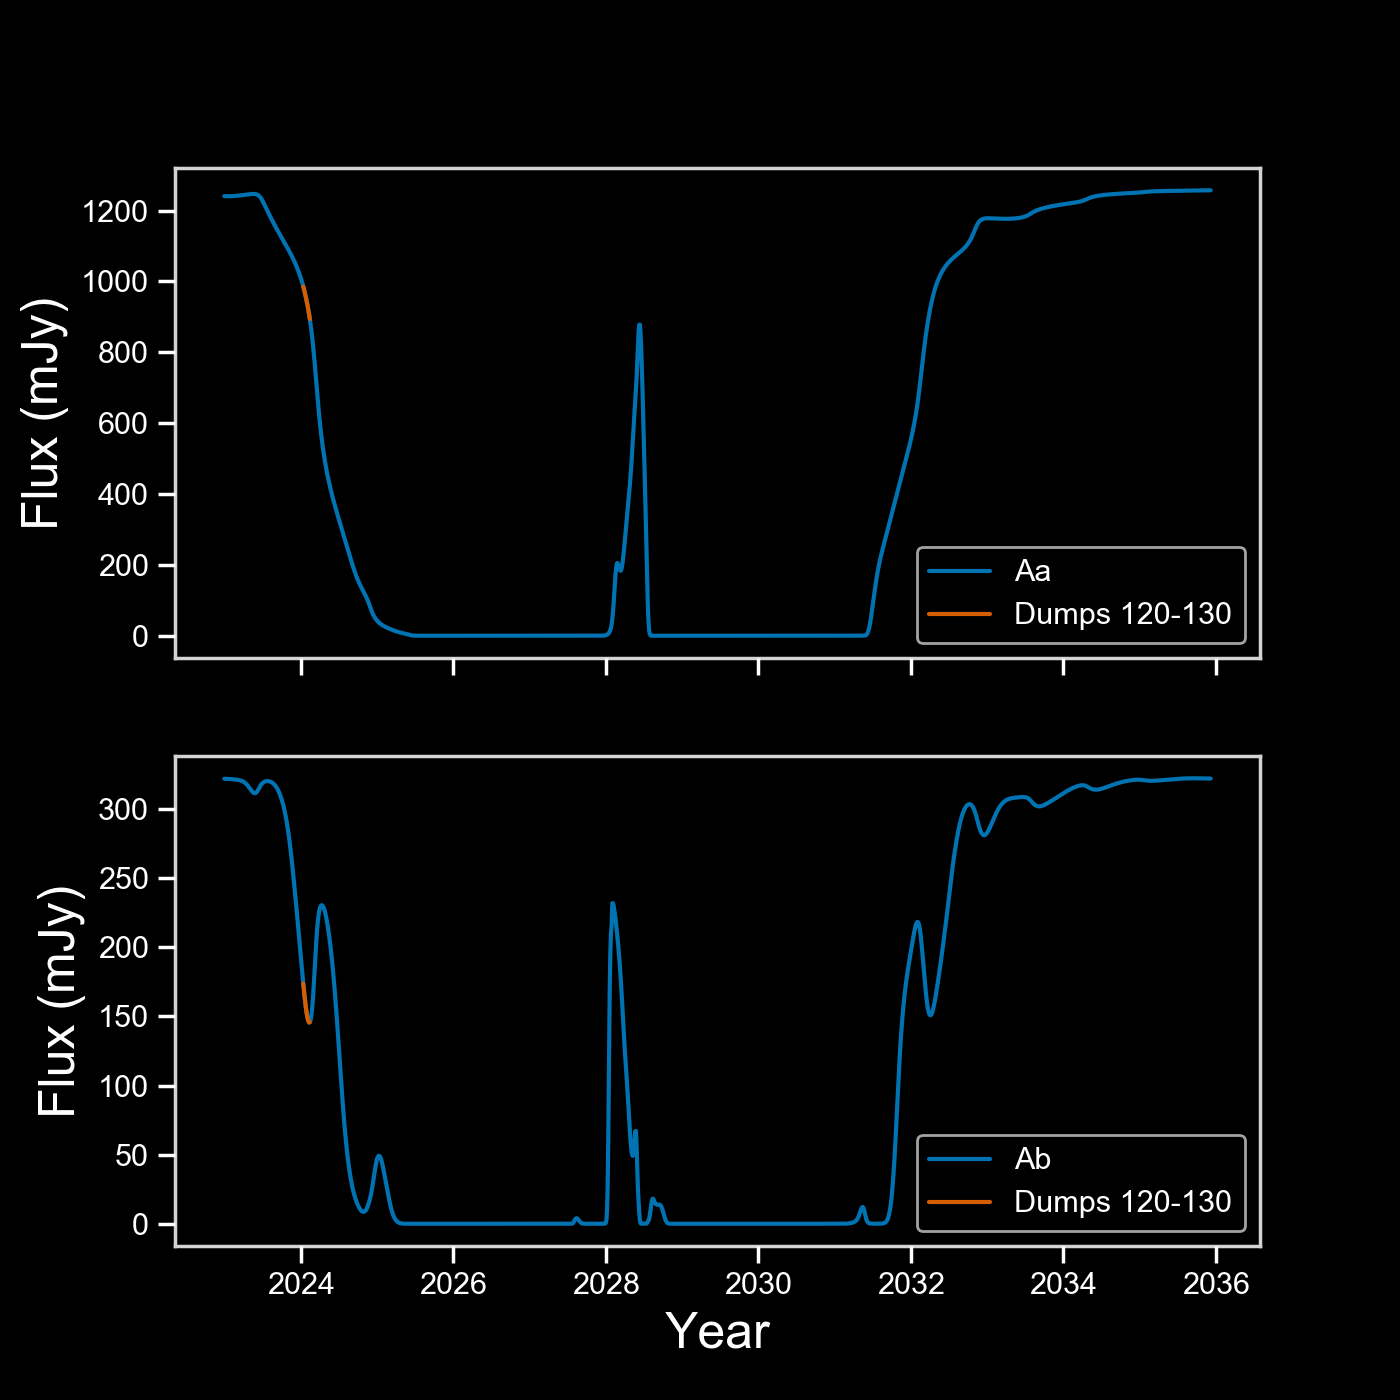

47350.6
0.0001932125190167978 11379.488158787211


In [6]:
fig, ax = plt.subplots(2, 1, figsize=(7,7), sharex=True)

extinction_data = pd.read_csv(
    './hd98800_30m_transit/extinction.out', 
    sep='\s+', 
    skiprows=[0,1,2,3,4], 
    names=[str(i) for i in range(5)]
)
f_A, f_B, f0_Aa, f0_Ab = interpolate_flux(0.8)
# [01 time days]  [02  sink1 [g/cm^2]]  [03  sink2 [g/cm^2]]  [04  sink3 [g/cm^2]]  [05  sink4 [g/cm^2]]
data = fits.open('./data_dust/kappa.fits.gz')
kappa = data[0].data[0]

times = extinction_data['0']
t_year = time.Time(t_ref - (40*P_B) + times, format='mjd').decimalyear
print(t_ref - (40*P_B))
tau_Aa = extinction_data['3']*kappa
tau_Ab = extinction_data['1']*kappa
print(np.min(tau_Aa), np.max(tau_Aa))

ax[0].plot(t_year, f0_Aa*np.exp(-tau_Aa), label='Aa')      # Aa 
ax[1].plot(t_year, f0_Ab*np.exp(-tau_Ab), label='Ab')      # Ab 
ax[0].plot(t_year[120:131], f0_Aa*np.exp(-tau_Aa)[120:131], c='r', label='Dumps 120-130')      # Aa 
ax[1].plot(t_year[120:131], f0_Ab*np.exp(-tau_Ab)[120:131], c='r', label='Dumps 120-130')      # Ab 
ax[1].set_xlabel('Year')
ax[0].set_ylabel('Flux (mJy)')
ax[1].set_ylabel('Flux (mJy)')

ax[0].legend()
ax[1].legend()



In [ ]:
# ==============================================

In [7]:
# home_dir = "/storage/astro2/phrkvg"
home_dir = '/home/astro/phrkvg'
wd = "hd98800_30m_transit"
dm = 0.33
wl = 0.8
odms_dir = f'./odms_{wl}um/odms_{wd}_{str(dm)}'
files = np.arange(400,1901)
dt = 0.05416
start_file = 400
start_dt = 0.5416

# Note only using discSink files for part 2 of dataset
data1 = merge_ev_files(1, wd=wd, ev_files=[1])    # Ab
data3 = merge_ev_files(3, wd=wd, ev_files=[1])    # Aa
data2 = merge_ev_files(2, wd=wd, ev_files=[1])    # Bb
data4 = merge_ev_files(4, wd=wd, ev_files=[1])    # Ba

times = ((start_file*start_dt)+((files-start_file)*dt))/(2*np.pi)
# times = (((files)*dt) + (start_file*start_dt))/(2*np.pi)
tau_Aa = np.zeros(len(files))
tau_Ab = np.zeros(len(files))
# No need to store tau at Ba and Bb

Aa_coords = np.empty((len(files), 2))
Ab_coords = np.empty((len(files), 2))
Ba_coords = np.empty((len(files), 2))
Bb_coords = np.empty((len(files), 2))

# Get x,y positions of stars Aa and Ab over time
Aa_pos = np.stack((np.array(data3['1']),np.array(data3['2'])))
Ab_pos = np.stack((np.array(data1['1']),np.array(data1['2'])))
Ba_pos = np.stack((np.array(data4['1']),np.array(data4['2'])))
Bb_pos = np.stack((np.array(data2['1']),np.array(data2['2'])))

# Shift all positions relative to the CoM of B
com_B = (m_Bb*Bb_pos + m_Ba*Ba_pos)/m_B
Aa_pos = Aa_pos - com_B
Ab_pos = Ab_pos - com_B
Ba_pos = Ba_pos - com_B
Bb_pos = Bb_pos - com_B

# Create interpolators for x,y positions of stars at time t
interp_Ba = interp1d(np.array(data4['0']),Ba_pos, bounds_error=False, fill_value=0)
interp_Bb = interp1d(np.array(data2['0']),Bb_pos, bounds_error=False, fill_value=0)
interp_Aa = interp1d(np.array(data3['0']),Aa_pos, bounds_error=False, fill_value=0)
interp_Ab = interp1d(np.array(data1['0']),Ab_pos, bounds_error=False, fill_value=0)

# Get r, phi values for ODM grid
grid_file = 'data_disk/grid.fits.gz'
hdu_list = fits.open(grid_file)
grid_data = hdu_list[0].data
print(grid_data.shape)


n_phi = len(grid_data[0,:,0,0])
n_rad = len(grid_data[0,0,0,:])
phi = np.linspace(0, np.max(grid_data[2,:,:,:]), n_phi)
r = np.logspace(np.log10(np.min(grid_data[0,:,:,:])), np.log10(np.max(grid_data[0,:,:,:])), n_rad)


for i, file in enumerate(files):
    file_no = str(file).rjust(5, '0')
    code_time = times[i]*2*np.pi
    
    # Get x,y coords at time t using interpolation 
    x_Aa, y_Aa = interp_Aa(code_time)
    x_Ab, y_Ab = interp_Ab(code_time)
    x_Ba, y_Ba = interp_Ba(code_time)
    x_Bb, y_Bb = interp_Bb(code_time)
    
    Aa_coords[i] = (x_Aa, y_Aa)
    Ab_coords[i] = (x_Ab, y_Ab)
    Ba_coords[i] = (x_Ba, y_Ba)
    Bb_coords[i] = (x_Bb, y_Bb)

    
    # Convert x,y to r,phi
    r_Aa = (x_Aa**2 + y_Aa**2)**0.5
    r_Ab = (x_Ab**2 + y_Ab**2)**0.5
    phi_Aa = np.arctan2(-y_Aa,-x_Aa)
    phi_Ab = np.arctan2(-y_Ab,-x_Ab)
    if phi_Aa < 0: phi_Aa = phi_Aa + 2*np.pi 
    if phi_Ab < 0: phi_Ab = phi_Ab + 2*np.pi 
    
    r_Ba = (x_Ba**2 + y_Ba**2)**0.5
    r_Bb = (x_Bb**2 + y_Bb**2)**0.5
    phi_Ba = np.arctan2(-y_Ba,-x_Ba)
    phi_Bb = np.arctan2(-y_Bb,-x_Bb)
    if phi_Ba < 0: phi_Ba = phi_Ba + 2*np.pi 
    if phi_Bb < 0: phi_Bb = phi_Bb + 2*np.pi 
    
    # Create interpolator for r,phi,tau from ODM
    try:
        opt_depth = fits.open(f'{odms_dir}/optical_depth_map_{file_no}.fits.gz')    # optical depth file
        opt_depth_data = opt_depth[0].data    # data in format [direction, phi, z, r]
        tau = opt_depth_data[1,:,0,:]
        print(tau.shape)

        fn = RegularGridInterpolator((phi,r), tau, bounds_error=False,  fill_value=0)

        # Get tau at r,phi of Aa and Ab using interpolation
        tau_Aa[i] = fn((phi_Aa, r_Aa))
        tau_Ab[i] = fn((phi_Ab, r_Ab))
        print(file, tau_Aa[i], tau_Ab[i],x_Aa, y_Aa)
        break

    except:
        # FileNotFoundError or ValueError or OSError
        tau_Aa[i] = np.nan
        tau_Ab[i] = np.nan
        print(f' ========== Error, corrupt or missing FITS file, or wrong grid dimensions: {file} ==========')
        


#     full_data = np.stack((times, tau_Aa, tau_Ab, Aa_coords[:,0], Aa_coords[:,1], Ab_coords[:,0], Ab_coords[:,1], Ba_coords[:,0], Ba_coords[:,1], Bb_coords[:,0], Bb_coords[:,1]), axis=1)
#     np.savetxt(f'tau_{wd}_{dm}_{wl}um_NEW.txt',full_data) # Data in format [time, tau_Aa, tau_Ab, x_Aa, y_Aa, x_Ab, y_Ab]



(3, 250, 200, 300)
(250, 300)
400 0.0 0.0 0.0 0.0


In [6]:
# home_dir = "/storage/astro2/phrkvg"
home_dir = '/home/astro/phrkvg'
wd = "hd98800_30m_transit"
dm = 0.33
wl = 0.8
odms_dir = f'./odms_{wl}um/odms_{wd}_{str(dm)}'
files = np.arange(400,1901)
dt = 0.05416
start_file = 400
start_dt = 0.5416

# Note only using discSink files for part 2 of dataset
data1 = merge_ev_files(1, wd=wd, ev_files=[1])    # Ab
data3 = merge_ev_files(3, wd=wd, ev_files=[1])    # Aa
data2 = merge_ev_files(2, wd=wd, ev_files=[1])    # Bb
data4 = merge_ev_files(4, wd=wd, ev_files=[1])    # Ba

times = ((start_file*start_dt)+((files-start_file)*dt))/(2*np.pi)
# times = (((files)*dt) + (start_file*start_dt))/(2*np.pi)
tau_Aa = np.zeros(len(files))
tau_Ab = np.zeros(len(files))
# No need to store tau at Ba and Bb

Aa_coords = np.empty((len(files), 2))
Ab_coords = np.empty((len(files), 2))
Ba_coords = np.empty((len(files), 2))
Bb_coords = np.empty((len(files), 2))

# Get x,y positions of stars Aa and Ab over time
Aa_pos = np.stack((np.array(data3['1']),np.array(data3['2'])))
Ab_pos = np.stack((np.array(data1['1']),np.array(data1['2'])))
Ba_pos = np.stack((np.array(data4['1']),np.array(data4['2'])))
Bb_pos = np.stack((np.array(data2['1']),np.array(data2['2'])))

# Shift all positions relative to the CoM of B
com_B = (m_Bb*Bb_pos + m_Ba*Ba_pos)/m_B
Aa_pos = Aa_pos - com_B
Ab_pos = Ab_pos - com_B
Ba_pos = Ba_pos - com_B
Bb_pos = Bb_pos - com_B

# Create interpolators for x,y positions of stars at time t
interp_Ba = interp1d(np.array(data4['0']),Ba_pos, bounds_error=False, fill_value=0)
interp_Bb = interp1d(np.array(data2['0']),Bb_pos, bounds_error=False, fill_value=0)
interp_Aa = interp1d(np.array(data3['0']),Aa_pos, bounds_error=False, fill_value=0)
interp_Ab = interp1d(np.array(data1['0']),Ab_pos, bounds_error=False, fill_value=0)

# Get r, phi values for ODM grid
grid_file = './data_disk/grid.fits.gz'
hdu_list = fits.open(grid_file)
grid_data = hdu_list[0].data
print(grid_data.shape)


n_phi = len(grid_data[0,:,0,0])
n_rad = len(grid_data[0,0,0,:])
phi = np.linspace(0, np.max(grid_data[2,:,:,:]), n_phi)
r = np.logspace(np.log10(np.min(grid_data[0,:,:,:])), np.log10(np.max(grid_data[0,:,:,:])), n_rad)


for i, file in enumerate(files):
    file_no = str(file).rjust(5, '0')
    code_time = times[i]*2*np.pi
    
    # Get x,y coords at time t using interpolation 
    x_Aa, y_Aa = interp_Aa(code_time)
    x_Ab, y_Ab = interp_Ab(code_time)
    x_Ba, y_Ba = interp_Ba(code_time)
    x_Bb, y_Bb = interp_Bb(code_time)
    
    Aa_coords[i] = (x_Aa, y_Aa)
    Ab_coords[i] = (x_Ab, y_Ab)
    Ba_coords[i] = (x_Ba, y_Ba)
    Bb_coords[i] = (x_Bb, y_Bb)

    
    # Convert x,y to r,phi
    r_Aa = (x_Aa**2 + y_Aa**2)**0.5
    r_Ab = (x_Ab**2 + y_Ab**2)**0.5
    phi_Aa = np.arctan2(-y_Aa,-x_Aa)
    phi_Ab = np.arctan2(-y_Ab,-x_Ab)
    if phi_Aa < 0: phi_Aa = phi_Aa + 2*np.pi 
    if phi_Ab < 0: phi_Ab = phi_Ab + 2*np.pi 
    
    r_Ba = (x_Ba**2 + y_Ba**2)**0.5
    r_Bb = (x_Bb**2 + y_Bb**2)**0.5
    phi_Ba = np.arctan2(-y_Ba,-x_Ba)
    phi_Bb = np.arctan2(-y_Bb,-x_Bb)
    if phi_Ba < 0: phi_Ba = phi_Ba + 2*np.pi 
    if phi_Bb < 0: phi_Bb = phi_Bb + 2*np.pi 
    
    # Create interpolator for r,phi,tau from ODM
    try:
        opt_depth = fits.open(f'{odms_dir}/optical_depth_map_{file_no}.fits.gz')    # optical depth file
        tau = opt_depth[0].data[1]    # data in format [direction, phi, z, r]
        print(tau.shape)

        fn = RegularGridInterpolator((phi,r), tau, bounds_error=False,  fill_value=0)

        # Get tau at r,phi of Aa and Ab using interpolation
        tau_Aa[i] = fn((phi_Aa, r_Aa))
        tau_Ab[i] = fn((phi_Ab, r_Ab))
        print(file, tau_Aa[i], tau_Ab[i],x_Aa, y_Aa)

    except:
        # FileNotFoundError or ValueError or OSError
        break
        tau_Aa[i] = np.nan
        tau_Ab[i] = np.nan
        print(f' ========== Error, corrupt or missing FITS file, or wrong grid dimensions: {file} ==========')
        


#     full_data = np.stack((times, tau_Aa, tau_Ab, Aa_coords[:,0], Aa_coords[:,1], Ab_coords[:,0], Ab_coords[:,1], Ba_coords[:,0], Ba_coords[:,1], Bb_coords[:,0], Bb_coords[:,1]), axis=1)
#     np.savetxt(f'tau_{wd}_{dm}_{wl}um_method2.txt',full_data) # Data in format [time, tau_Aa, tau_Ab, x_Aa, y_Aa, x_Ab, y_Ab]



(3, 250, 200, 300)
(997448,)


In [ ]:
# Amend existing file

home_dir = "/storage/astro2/phrkvg"
# home_dir = '/home/astro/phrkvg'
wd = "hd98800_30m_transit"
dm = 0.33
wl = 0.8
odms_dir = f'./odms_{wl}um/odms_{wd}_{str(dm)}'
old_data = np.loadtxt(f'tau_{wd}_{str(dm)}_{wl}um_NEW.txt')


files = np.arange(799,800)
dt = 0.05416
start_file = 400
start_dt = 0.5416


# Note only using discSink files for part 2 of dataset
data1 = merge_ev_files(1, wd=wd, ev_files=[1])    # Ab
data3 = merge_ev_files(3, wd=wd, ev_files=[1])    # Aa
data2 = merge_ev_files(2, wd=wd, ev_files=[1])    # Bb
data4 = merge_ev_files(4, wd=wd, ev_files=[1])    # Ba

times = (((files)*dt) + (start_file*start_dt))/(2*np.pi)
tau_Aa = np.zeros(len(files))
tau_Ab = np.zeros(len(files))
# No need to store tau at Ba and Bb

Aa_coords = np.empty((len(files), 2))
Ab_coords = np.empty((len(files), 2))
Ba_coords = np.empty((len(files), 2))
Bb_coords = np.empty((len(files), 2))

# Get x,y positions of stars Aa and Ab over time
Aa_pos = np.stack((np.array(data3['1']),np.array(data3['2'])))
Ab_pos = np.stack((np.array(data1['1']),np.array(data1['2'])))
Ba_pos = np.stack((np.array(data4['1']),np.array(data4['2'])))
Bb_pos = np.stack((np.array(data2['1']),np.array(data2['2'])))

# Shift all positions relative to the CoM of B
com_B = (m_Bb*Bb_pos + m_Ba*Ba_pos)/m_B
Aa_pos = Aa_pos - com_B
Ab_pos = Ab_pos - com_B
Ba_pos = Ba_pos - com_B
Bb_pos = Bb_pos - com_B

# Create interpolators for x,y positions of stars at time t
interp_Ba = interp1d(np.array(data4['0']),Ba_pos, bounds_error=False, fill_value=0)
interp_Bb = interp1d(np.array(data2['0']),Bb_pos, bounds_error=False, fill_value=0)
interp_Aa = interp1d(np.array(data3['0']),Aa_pos, bounds_error=False, fill_value=0)
interp_Ab = interp1d(np.array(data1['0']),Ab_pos, bounds_error=False, fill_value=0)

# Get r, phi values for ODM grid
grid_file = './data_disk/grid.fits.gz'
hdu_list = fits.open(grid_file)
grid_data = hdu_list[0].data
print(grid_data.shape)

n_phi = len(grid_data[0,:,0,0])
n_rad = len(grid_data[0,0,0,:])
phi = np.linspace(0, np.max(grid_data[2,:,:,:]), n_phi)
r = np.logspace(np.log10(np.min(grid_data[0,:,:,:])), np.log10(np.max(grid_data[0,:,:,:])), n_rad)

new_data = old_data.copy()


for i, file in enumerate(files):
    file_no = str(file).rjust(5, '0')
    code_time = times[i]*2*np.pi
    
    # Get x,y coords at time t using interpolation 
    x_Aa, y_Aa = interp_Aa(code_time)
    x_Ab, y_Ab = interp_Ab(code_time)
    x_Ba, y_Ba = interp_Ba(code_time)
    x_Bb, y_Bb = interp_Bb(code_time)
    
    Aa_coords[i] = (x_Aa, y_Aa)
    Ab_coords[i] = (x_Ab, y_Ab)
    Ba_coords[i] = (x_Ba, y_Ba)
    Bb_coords[i] = (x_Bb, y_Bb)

    
    # Convert x,y to r,phi
    r_Aa = (x_Aa**2 + y_Aa**2)**0.5
    r_Ab = (x_Ab**2 + y_Ab**2)**0.5
    phi_Aa = np.arctan2(-y_Aa,-x_Aa)
    phi_Ab = np.arctan2(-y_Ab,-x_Ab)
    if phi_Aa < 0: phi_Aa = phi_Aa + 2*np.pi 
    if phi_Ab < 0: phi_Ab = phi_Ab + 2*np.pi 
    
    r_Ba = (x_Ba**2 + y_Ba**2)**0.5
    r_Bb = (x_Bb**2 + y_Bb**2)**0.5
    phi_Ba = np.arctan2(-y_Ba,-x_Ba)
    phi_Bb = np.arctan2(-y_Bb,-x_Bb)
    if phi_Ba < 0: phi_Ba = phi_Ba + 2*np.pi 
    if phi_Bb < 0: phi_Bb = phi_Bb + 2*np.pi 
    
    # Create interpolator for r,phi,tau from ODM
    try:
        opt_depth = fits.open(f'{odms_dir}/optical_depth_map_{file_no}.fits.gz')    # optical depth file
        opt_depth_data = opt_depth[0].data    # data in format [direction, phi, z, r]
        tau = opt_depth_data[1,:,0,:]

        fn = RegularGridInterpolator((phi,r), tau, bounds_error=False,  fill_value=0)

        # Get tau at r,phi of Aa and Ab using interpolation
        new_data[file-start_file,1] = fn((phi_Aa, r_Aa))
        new_data[file-start_file,2] = fn((phi_Ab, r_Ab))
        print(file, old_data[file-start_file,1], old_data[file-start_file,2], ' --> ', new_data[file-start_file,1], new_data[file-start_file,2])
        print(x_Aa,y_Aa,x_Ab,y_Ab)
    except:
        # FileNotFoundError or ValueError or OSError
        new_data[file-start_file,1] = np.nan
        new_data[file-start_file,2] = np.nan
        print(f' ================== Error, corrupt or missing FITS file: {file} =================')
        
    new_data[file,3] = x_Aa
    new_data[file,4] = y_Aa
    new_data[file,5] = x_Ab
    new_data[file,6] = y_Ab
    new_data[file,7] = x_Ba
    new_data[file,8] = y_Ba
    new_data[file,9] = x_Bb
    new_data[file,10] = y_Bb
    np.savetxt(f'tau_{wd}_{dm}_{wl}um_NEW_v2.txt', new_data) # Data in format [time, tau_Aa, tau_Ab, x_Aa, y_Aa, x_Ab, y_Ab]



In [10]:
sim = 'hd98800_30m_transit'
dm = 0.33
wl = 0.8
data = np.loadtxt(f'tau_{sim}_{str(dm)}_{wl}um.txt')
f_A, f_B, f0_Aa, f0_Ab = interpolate_flux(wl)
t_year = time.Time(t_ref - (40*P_B) + (times)*365.25, format='mjd').decimalyear
print(len(data))
print(t_year[0])
# data2 = np.loadtxt(f'tau_{sim2}.txt')
times = data[:,0]
tau_Aa = data[:,1]
tau_Ab = data[:,2]
x_Aas = data[:,3]
y_Aas = data[:,4]
x_Abs = data[:,5]
y_Abs = data[:,6]

x_Bas = data[:,7]
y_Bas = data[:,8]
x_Bbs = data[:,9]
y_Bbs = data[:,10]


Aa_colour = 'pink'
Ab_colour = 'limegreen'
Bb_colour = 'cyan'
Ba_colour = 'yellow'

print(f_A,f_B)


1901
2019.550182810439
1580.0 1360.0


<IPython.core.display.Javascript object>


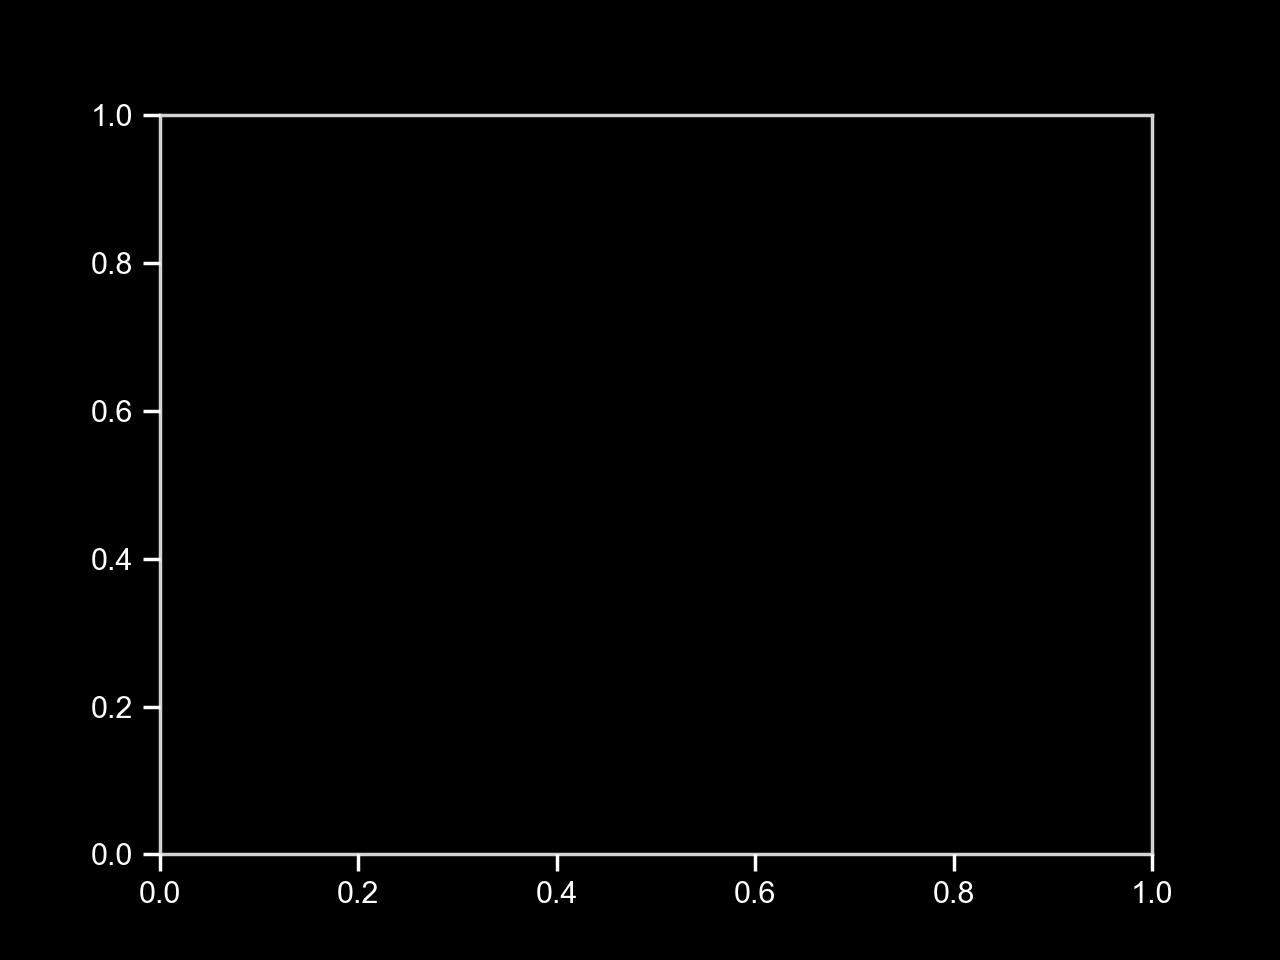

ValueError: x and y must be the same size

In [8]:
fig = plt.figure()
plt.scatter(t_year, tau_Aa, label='Aa')
# plt.plot(times, tau_Ab, label='Ab')
plt.legend()


<IPython.core.display.Javascript object>


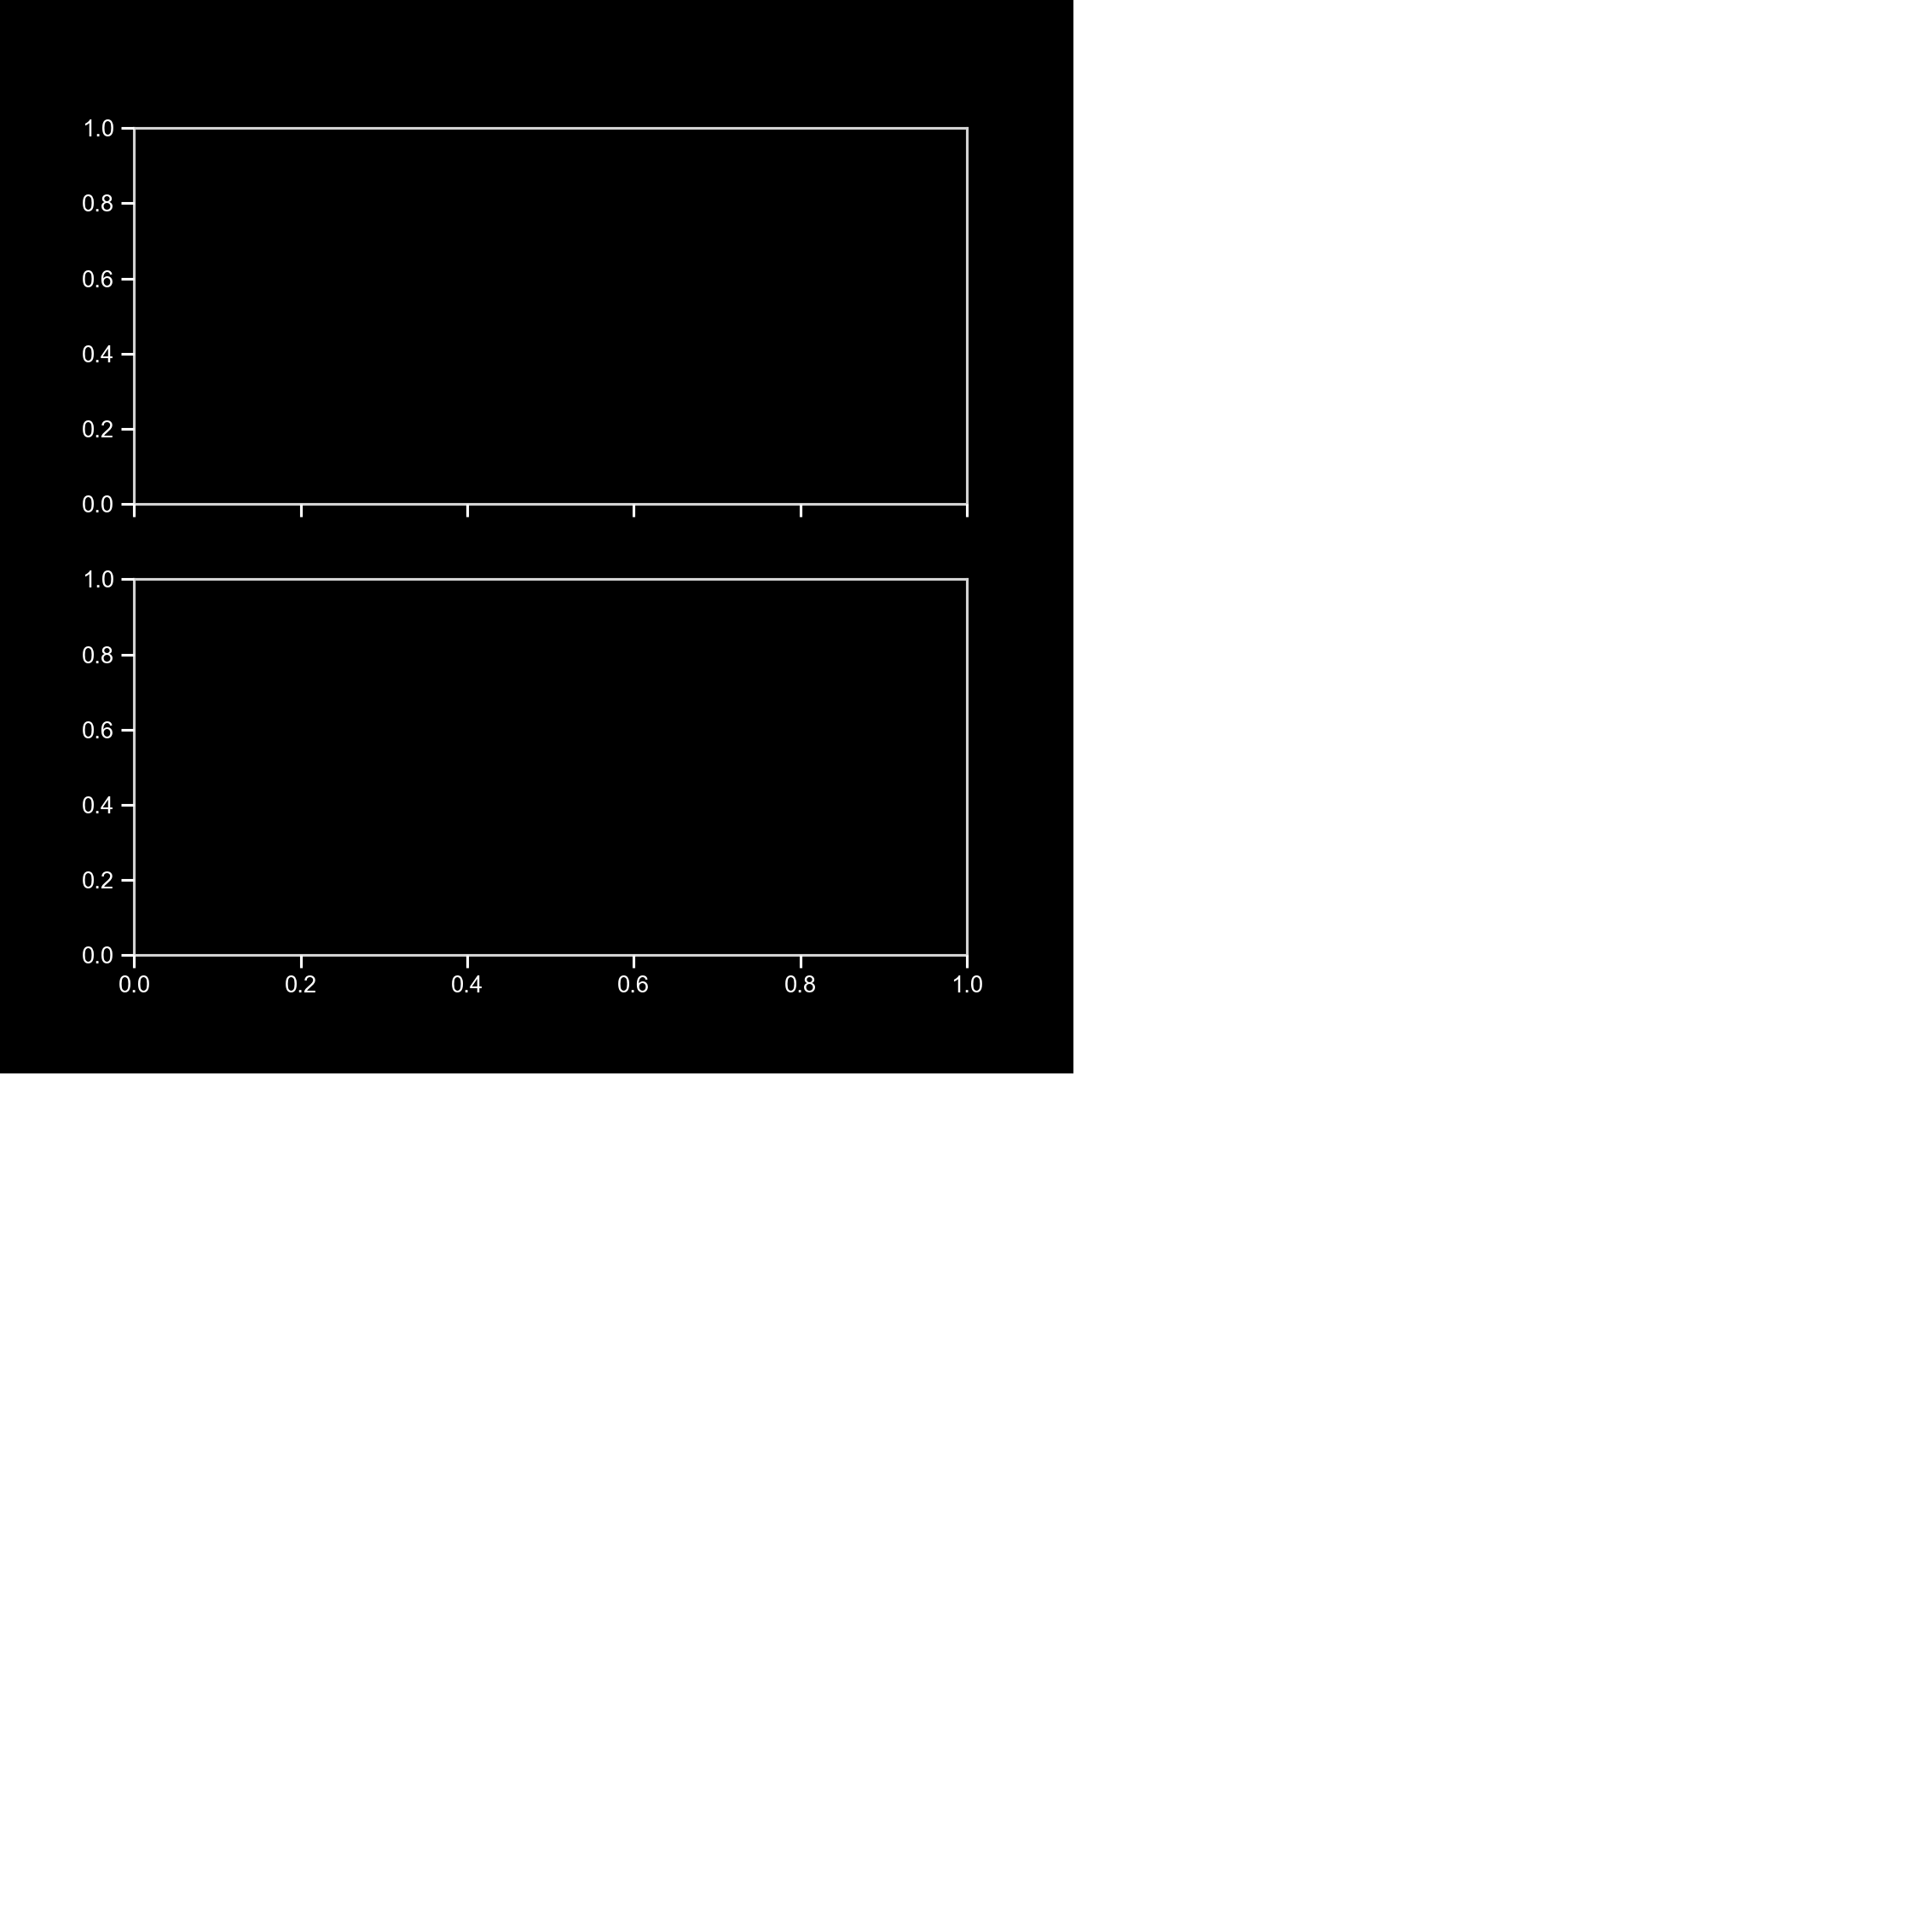

NameError: name 't_ref' is not defined

In [8]:
fig, ax = plt.subplots(2, 1, figsize=(7,7), sharex=True)

f_Aa = f0_Aa*np.exp(-tau_Aa)
f_Ab = f0_Ab*np.exp(-tau_Ab)

t_year = time.Time(t_ref - (40*P_B) + (times)*365.25, format='mjd').decimalyear
# t_year = time.Time(t_ref - (420000) + (times)*365.25, format='mjd').decimalyear

ax[0,].plot(t_year, f_Aa, color='red')
ax[1,].plot(t_year, f_Ab, color='blue')
ax[0,].set_title('Aa')
ax[1,].set_title('Ab')
ax[0,].set_ylabel('Flux (mJy)')
ax[1,].set_ylabel('Flux (mJy)')
ax[1,].set_xlabel('Year')
# ax[0,].set_xlim(np.ceil(min(t_year))+1, max(t_year))
# ax[1,].set_xlim(np.ceil(min(t_year))+1, max(t_year))

ax[0,].set_ylim(-round(f0_Aa*0.1, -1), round(f0_Aa*1.1, -1))
ax[1,].set_ylim(-round(f0_Ab*0.1, 0), round(f0_Ab*1.1, -1))

f_norm_Aa = lambda f: f/f0_Aa
f_denorm_Aa = lambda f: f*f0_Aa
f_norm_Ab = lambda f: f/f0_Ab
f_denorm_Ab = lambda f: f*f0_Ab

secax0 = ax[0].secondary_yaxis(location='right', functions=(f_norm_Aa, f_denorm_Aa))
secax0.set_ylabel('Nomalised flux')
secax1 = ax[1].secondary_yaxis(location='right', functions=(f_norm_Ab, f_denorm_Ab))
secax1.set_ylabel('Nomalised flux')

plt.tight_layout()
print(tau_Aa[1330:1380])

In [ ]:
fig, ax = plt.subplots(1, figsize=(10,7))

f_tot = f0_Aa*np.exp(-tau_Aa) + f0_Ab*np.exp(-tau_Ab) + f_B
t_year = time.Time(t_ref - (40*P_B) + (times)*365.25, format='mjd').decimalyear

ax.plot(np.arange(len(t_year)), f_tot, color='white')
ax.set_ylabel('Flux (mJy)')
ax.set_xlabel('Year')
# ax.set_xlim(np.ceil(min(t_year))+1, (max(t_year)))
print(np.ceil(min(t_year)))

f_norm = lambda f: f/(f_A+f_B)
f_denorm = lambda f: f*(f_A+f_B)


secax0 = ax.secondary_yaxis(location='right', functions=(f_norm, f_denorm))
secax0.set_ylabel('Nomalised flux')


plt.tight_layout()


In [ ]:
fig, ax = plt.subplots(1, figsize=(10,7))

f_A, f_B, f0_Aa, f0_Ab = interpolate_flux(0.8)

data_ref = np.loadtxt(f'tau_hd98800_30m_transit_{str(dm)}_{wl}um.txt')

times = data[:,0]
tau_Aa = data[:,1]
tau_Ab = data[:,2]


f_tot = f0_Aa*np.exp(-tau_Aa) + f0_Ab*np.exp(-tau_Ab) + f_B
t_year = time.Time(t_ref - (40*P_B) + (times)*365.25, format='mjd').decimalyear

ax.plot(times, f_tot, color='black')
ax.set_ylabel('Flux (mJy)')
ax.set_xlabel('Year')
# ax.set_xlim(np.ceil(min(t_year))+1, (max(t_year)))
print(np.ceil(min(t_year)))

f_norm = lambda f: f/(f_A+f_B)
f_denorm = lambda f: f*(f_A+f_B)


secax0 = ax.secondary_yaxis(location='right', functions=(f_norm, f_denorm))
secax0.set_ylabel('Nomalised flux')


plt.tight_layout()


In [ ]:
plt.clf()
plt.figure(figsize=(10,7))

f_Aa = f0_Aa*np.exp(-tau_Aa)
f_Ab = f0_Ab*np.exp(-tau_Ab)
f_tot = f0_Aa*np.exp(-tau_Aa) + f0_Ab*np.exp(-tau_Ab) + f_B

t_year = time.Time(t_ref - (40*P_B) + (times)*365.25, format='mjd').decimalyear

ax1 = plt.subplot2grid((10, 10), (6, 6), colspan=4, rowspan=4)
ax1.plot(t_year, f_Aa, color='red')

ax2 = plt.subplot2grid((10, 10), (6, 0), colspan=4, rowspan=4)
ax2.plot(t_year, f_Ab, color='cyan')

ax3 = plt.subplot2grid((10, 10), (0, 0), colspan=10, rowspan=5)
ax3.plot(t_year, f_tot, color='white')

ax1.set_title('Aa')
ax2.set_title('Ab')
ax1.set_ylabel('Flux (mJy)')
ax2.set_ylabel('Flux (mJy)')
ax3.set_ylabel('Flux (mJy)')
ax1.set_xlabel('Year')
ax2.set_xlabel('Year')
ax3.set_xlabel('Year')
ax1.set_xlim(np.ceil(min(t_year))+2, np.floor(max(t_year)))
ax1.set_xlim(np.ceil(min(t_year))+2, np.floor(max(t_year)))
ax2.set_xlim(np.ceil(min(t_year))+2, np.floor(max(t_year)))
ax2.set_xlim(np.ceil(min(t_year))+2, np.floor(max(t_year)))
ax3.set_xlim(np.ceil(min(t_year))+2, np.floor(max(t_year)))
ax3.set_xlim(np.ceil(min(t_year))+2, np.floor(max(t_year)))
ax1.set_xticks([2022, 2025,2028,2031,2034])
ax2.set_xticks([2022, 2025,2028,2031,2034])
ax2.set_yticks([0,100,200,300,400])
ax1.set_yticks([0,300,600,900,1200])

ax1.set_ylim(-round(f0_Aa*0.1, -1), round(f0_Aa*1.1, -1))
ax2.set_ylim(-round(f0_Ab*0.1, -1), round(f0_Ab*1.1, -1))

f_norm_Aa = lambda f: f/f0_Aa
f_denorm_Aa = lambda f: f*f0_Aa
f_norm_Ab = lambda f: f/f0_Ab
f_denorm_Ab = lambda f: f*f0_Ab

secax1 = ax1.secondary_yaxis(location='right', functions=(f_norm_Aa, f_denorm_Aa))
secax1.set_ylabel('Nomalised flux')
secax1.set_yticks([0,0.2,0.4,0.6,0.8,1.0])
secax2 = ax2.secondary_yaxis(location='right', functions=(f_norm_Ab, f_denorm_Ab))
secax2.set_ylabel('Nomalised flux')
secax2.set_yticks([0,0.2,0.4,0.6,0.8,1.0])


f_norm = lambda f: f/(f_A+f_B)
f_denorm = lambda f: f*(f_A+f_B)


secax3 = ax3.secondary_yaxis(location='right', functions=(f_norm, f_denorm))
secax3.set_ylabel('Nomalised flux')
secax3.set_yticks([0.4,0.5,0.6,0.7,0.8,0.9,1.0])


plt.tight_layout()
plt.show()

In [ ]:
plt.clf()
plt.figure(figsize=(10,4))

f_Aa = f0_Aa*np.exp(-tau_Aa)
f_Ab = f0_Ab*np.exp(-tau_Ab)
f_tot = f0_Aa*np.exp(-tau_Aa) + f0_Ab*np.exp(-tau_Ab) + f_B

t_year = time.Time(t_ref - (40*P_B) + (times)*365.25, format='mjd').decimalyear
# t_year = time.Time(t_ref - (420000) + (times)*365.25, format='mjd').decimalyear

ax2 = plt.subplot2grid((20, 20), (12,14), colspan=9, rowspan=9)
ax2.plot(t_year, f_Ab, color='black', linewidth=1)

ax1 = plt.subplot2grid((20, 20), (0, 14), colspan=9, rowspan=9, sharex=ax2)
ax1.plot(t_year, f_Aa, color='black', linewidth=1)

ax3 = plt.subplot2grid((20, 20), (0, 0), colspan=11, rowspan=20)
ax3.plot(t_year, f_tot, color='black')

ax1.set_title('Aa')
ax2.set_title('Ab')
ax1.set_ylabel('Flux (mJy)')
ax2.set_ylabel('Flux (mJy)')
ax3.set_ylabel('Flux (mJy)')
# ax1.set_xlabel('Year')
ax2.set_xlabel('Year')
ax3.set_xlabel('Year')
ax1.set_xlim(np.ceil(min(t_year))+1, np.floor(max(t_year)))
ax1.set_xlim(np.ceil(min(t_year))+1, np.floor(max(t_year)))
ax2.set_xlim(np.ceil(min(t_year))+1, np.floor(max(t_year)))
ax2.set_xlim(np.ceil(min(t_year))+1, np.floor(max(t_year)))
ax3.set_xlim(np.ceil(min(t_year))+1, np.floor(max(t_year)))
ax3.set_xlim(np.ceil(min(t_year))+1, np.floor(max(t_year)))
ax1.set_xticks([2022, 2025,2028,2031,2034])
ax1.tick_params(labelbottom=False)    
ax2.set_xticks([2022, 2025,2028,2031,2034])
ax1.set_yticks(np.linspace(0,round(f0_Aa, -2), 3))
ax2.set_yticks(np.linspace(0,round(f0_Ab, -2), 3))
ax3.set_yticks(np.linspace(round(0.4*(f0_Aa+f0_Ab+f_B), -2),round(f0_Aa+f0_Ab+f_B, -2)+100, 7))

ax1.set_ylim(-round(f0_Aa*0.1, -1), round(f0_Aa*1.1, -1))
ax2.set_ylim(-round(f0_Ab*0.1, 0), round(f0_Ab*1.1, -1))

f_norm_Aa = lambda f: f/f0_Aa
f_denorm_Aa = lambda f: f*f0_Aa
f_norm_Ab = lambda f: f/f0_Ab
f_denorm_Ab = lambda f: f*f0_Ab

secax1 = ax1.secondary_yaxis(location='right', functions=(f_norm_Aa, f_denorm_Aa))
secax1.set_ylabel('Normalised flux')
secax1.set_yticks([0.2,0.6,1.0])
secax2 = ax2.secondary_yaxis(location='right', functions=(f_norm_Ab, f_denorm_Ab))
secax2.set_ylabel('Normalised flux')
secax2.set_yticks([0.2,0.6,1.0])


f_norm = lambda f: f/(f_A+f_B)
f_denorm = lambda f: f*(f_A+f_B)


secax3 = ax3.secondary_yaxis(location='right', functions=(f_norm, f_denorm))
secax3.set_ylabel('Normalised flux')
secax3.set_yticks([0.4,0.5,0.6,0.7,0.8,0.9,1.0])


plt.tight_layout()
plt.subplots_adjust(hspace=0, left=0.07, right=0.94, top=0.93, bottom=0.12)

plt.show()
plt.savefig(f'LC_ref.png', dpi=150)

In [ ]:
plt.clf()
plt.figure(figsize=(10,4))

f_Aa = f0_Aa*np.exp(-tau_Aa)
f_Ab = f0_Ab*np.exp(-tau_Ab)
f_tot = f0_Aa*np.exp(-tau_Aa) + f0_Ab*np.exp(-tau_Ab) + f_B

t_year = time.Time(t_ref - (40*P_B) + (times)*365.25, format='mjd').decimalyear
# t_year = time.Time(t_ref - (420000) + (times)*365.25, format='mjd').decimalyear

ax2 = plt.subplot2grid((100, 100), (50,80), colspan=20, rowspan=30)
ax2.plot(t_year, f_Ab, color='white', linewidth=1)

ax1 = plt.subplot2grid((100, 100), (0, 80), colspan=20, rowspan=30, sharex=ax2)
ax1.plot(t_year, f_Aa, color='white', linewidth=1)

ax3 = plt.subplot2grid((100, 100), (0, 0), colspan=35, rowspan=80)
ax3.plot(t_year, f_tot, color='white')

ax1.set_title('Aa')
ax2.set_title('Ab')
ax1.set_ylabel('Flux (mJy)')
ax2.set_ylabel('Flux (mJy)')
ax3.set_ylabel('Flux (mJy)')
# ax1.set_xlabel('Year')
ax2.set_xlabel('Year')
ax3.set_xlabel('Year')
ax1.set_xlim(np.ceil(min(t_year))+2, np.floor(max(t_year))-1)
ax1.set_xlim(np.ceil(min(t_year))+2, np.floor(max(t_year))-1)
ax2.set_xlim(np.ceil(min(t_year))+2, np.floor(max(t_year))-1)
ax2.set_xlim(np.ceil(min(t_year))+2, np.floor(max(t_year))-1)
ax3.set_xlim(np.ceil(min(t_year))+2, np.floor(max(t_year))-1)
ax3.set_xlim(np.ceil(min(t_year))+2, np.floor(max(t_year))-1)
ax1.set_xticks([2022, 2025,2028,2031,2034])
ax1.tick_params(labelbottom=False)    
ax2.set_xticks([2022, 2025,2028,2031,2034])
ax1.set_yticks(np.linspace(0,round(f0_Aa, -2), 3))
ax2.set_yticks(np.linspace(0,round(f0_Ab, -2), 3))
ax3.set_yticks(np.linspace(round(0.4*(f0_Aa+f0_Ab+f_B), -2),round(f0_Aa+f0_Ab+f_B, -2)+100, 7))

# Plot ODM with stars


ax1.set_ylim(-round(f0_Aa*0.1, -1), round(f0_Aa*1.1, -1))
ax2.set_ylim(-round(f0_Ab*0.1, 0), round(f0_Ab*1.1, -1))

f_norm_Aa = lambda f: f/f0_Aa
f_denorm_Aa = lambda f: f*f0_Aa
f_norm_Ab = lambda f: f/f0_Ab
f_denorm_Ab = lambda f: f*f0_Ab

secax1 = ax1.secondary_yaxis(location='right', functions=(f_norm_Aa, f_denorm_Aa))
secax1.set_ylabel('Normalised flux')
secax1.set_yticks([0.2,0.6,1.0])
secax2 = ax2.secondary_yaxis(location='right', functions=(f_norm_Ab, f_denorm_Ab))
secax2.set_ylabel('Normalised flux')
secax2.set_yticks([0.2,0.6,1.0])


f_norm = lambda f: f/(f_A+f_B)
f_denorm = lambda f: f*(f_A+f_B)


secax3 = ax3.secondary_yaxis(location='right', functions=(f_norm, f_denorm))
secax3.set_ylabel('Normalised flux')
secax3.set_yticks([0.4,0.5,0.6,0.7,0.8,0.9,1.0])


plt.tight_layout()
plt.subplots_adjust(hspace=0, left=0.07, right=0.94, top=0.93, bottom=0.12)

plt.show()
plt.savefig(f'LC_ref.png', dpi=150)

<IPython.core.display.Javascript object>


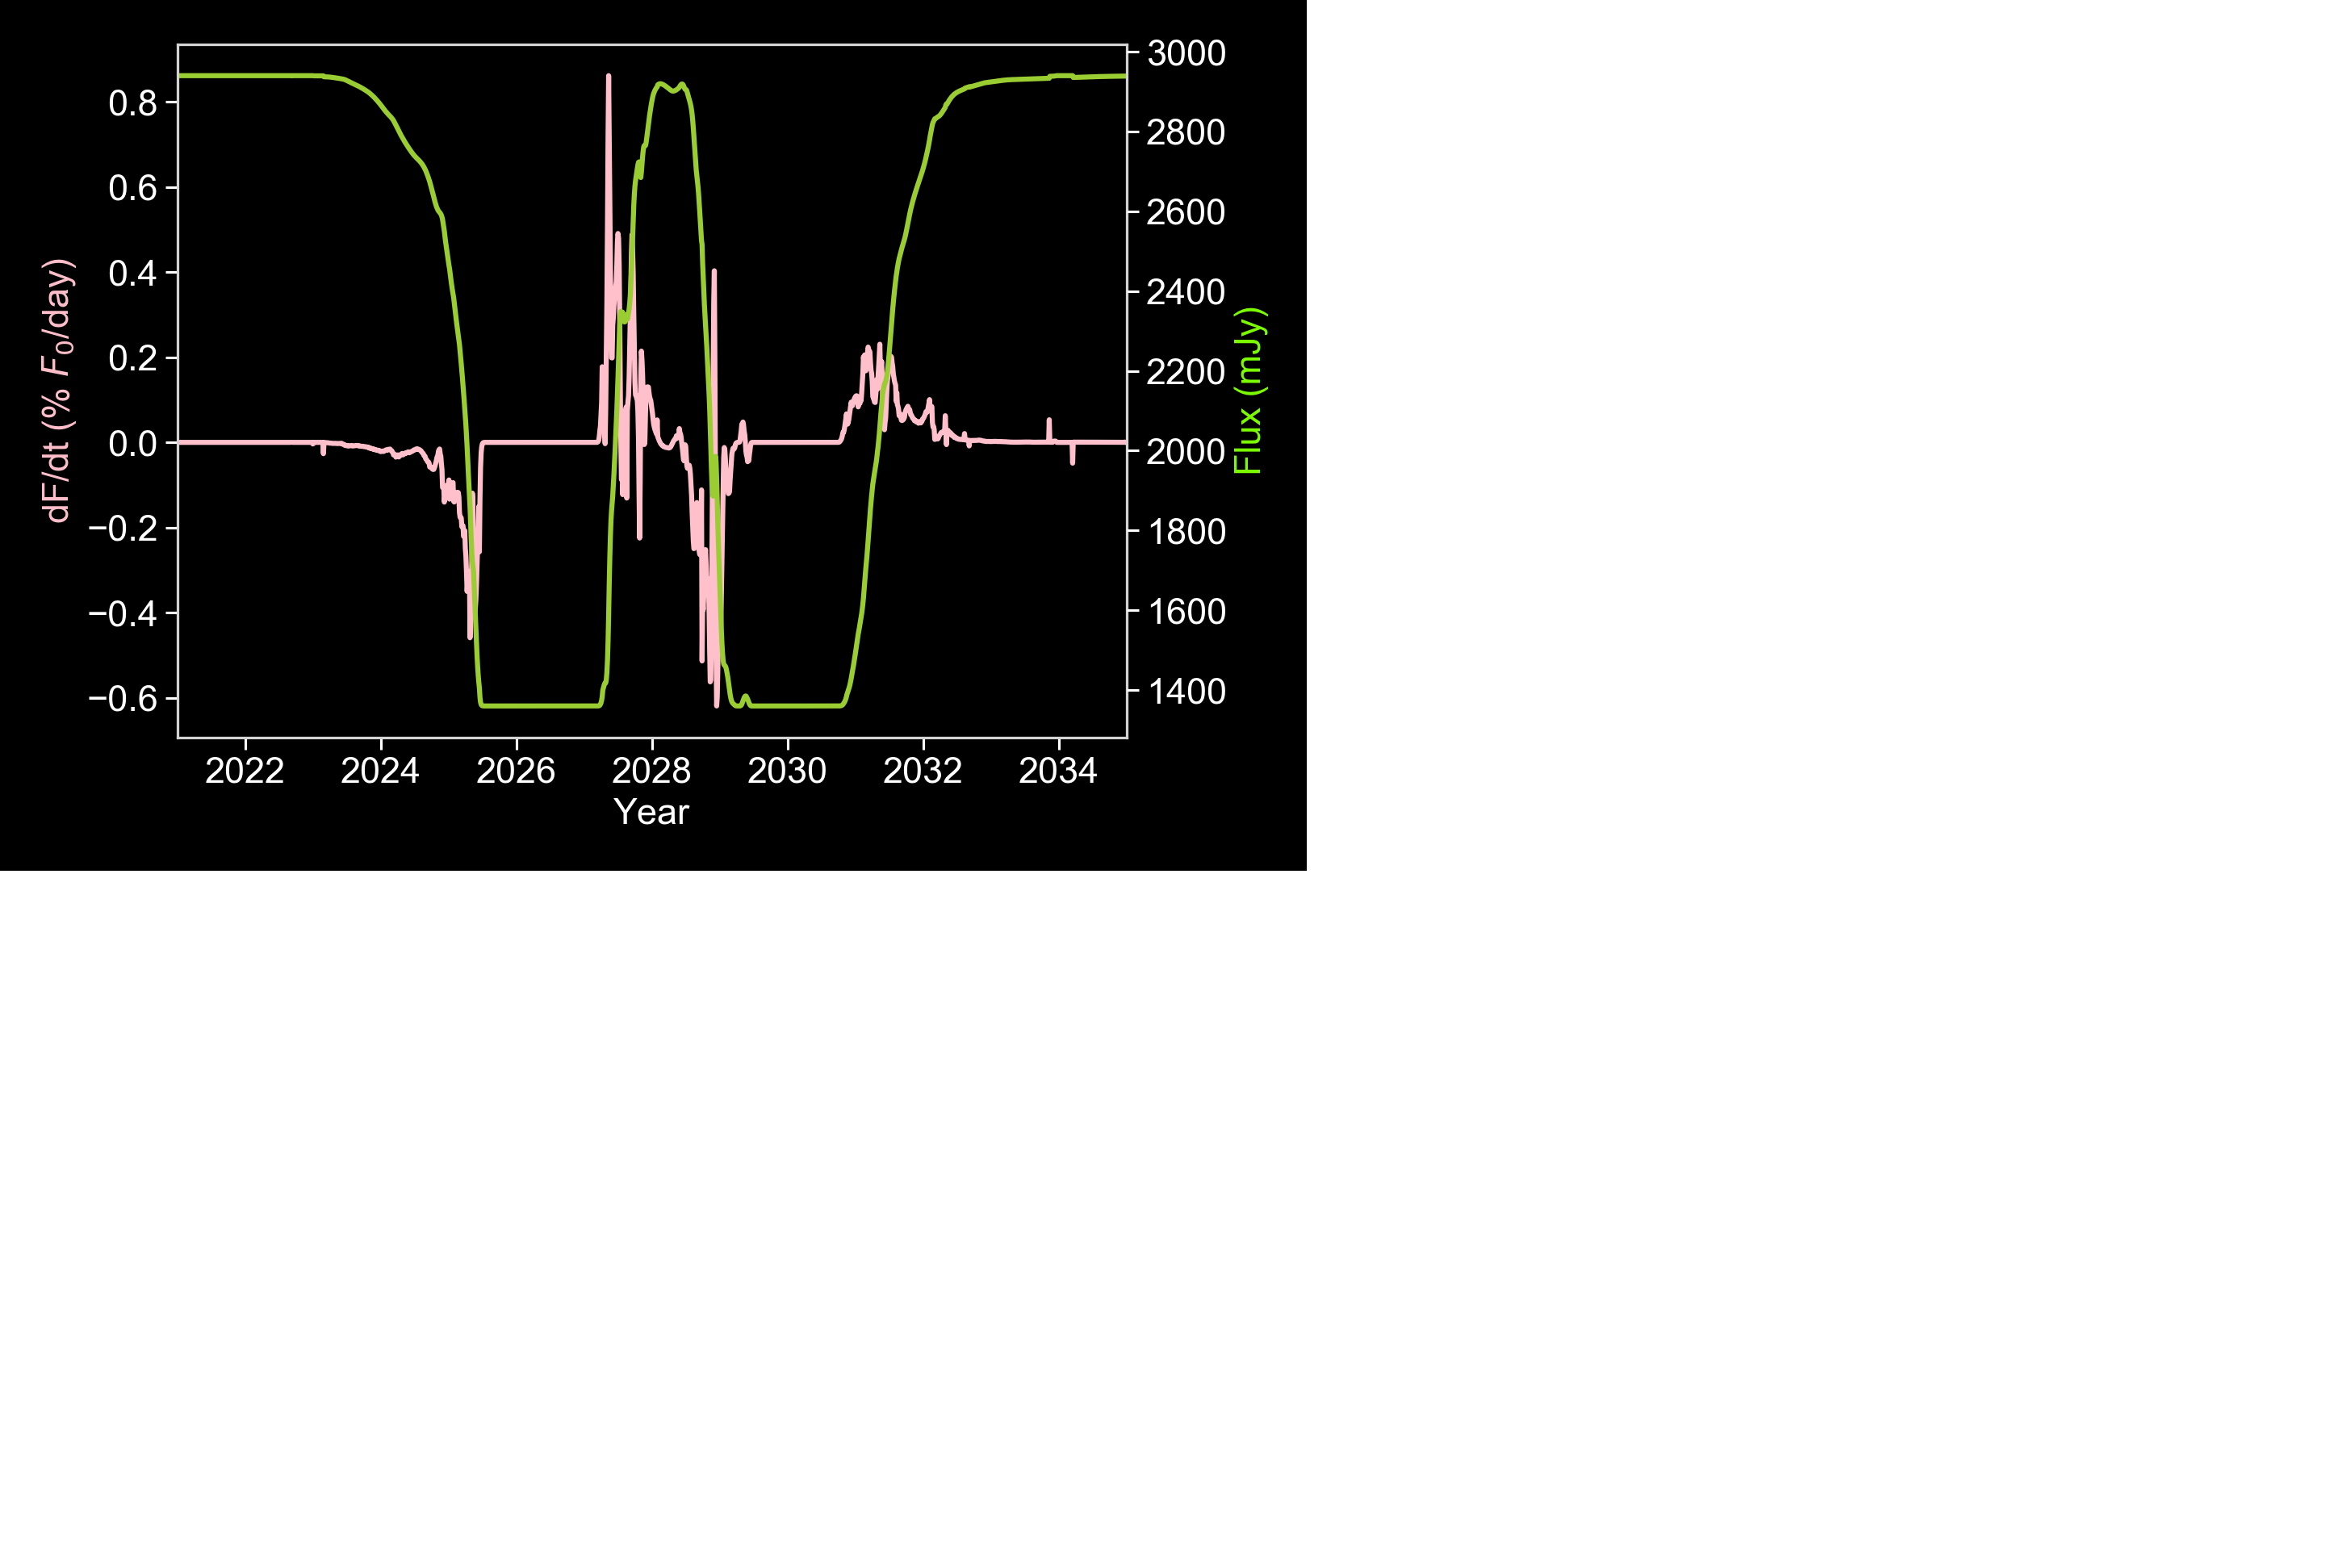

2940.0


In [20]:
fig, ax = plt.subplots(1, figsize=(9,6))

models = [
    'hd98800_30m_transit_0.33_0.8', 
#     'hd98800_30m_transit_0.033_0.8', 
#     'hd98800_30m_transit_3.3_0.8', 
#     'alpha_1e-2_transit_0.33_0.8', 
#     'alpha_5e-2_0.33_0.8'
]

wl=0.8

for model in models:
    data = np.loadtxt(f'tau_{model}um.txt')
    f_A, f_B, f0_Aa, f0_Ab = interpolate_flux(wl)
    # data2 = np.loadtxt(f'tau_{sim2}.txt')
    times = data[:,0]
    tau_Aa = data[:,1]
    tau_Ab = data[:,2]


    f_tot = f0_Aa*np.exp(-tau_Aa) + f0_Ab*np.exp(-tau_Ab) + f_B
    t_days = time.Time(t_ref - (40*P_B) + (times)*365.25, format='mjd').mjd
    t_year = time.Time(t_ref - (40*P_B) + (times)*365.25, format='mjd').decimalyear
    dfdt = np.diff(f_tot)/np.diff(t_days)
    # t_year = time.Time(t_ref - (420000) + (times)*365.25, format='mjd').decimalyear

    ax.plot(t_year[:-1], dfdt*100/(f_A+f_B), label=model, c='pink', linewidth=2.5)
    
    ax2 = ax.twinx()
    ax2.plot(t_year, f_tot, c='yellowgreen', alpha=1, linewidth=2.5)
    ax2.set_ylabel('Flux (mJy)', c='lawngreen')

# ax.plot(t_year, f_tot, color='red')
ax.set_ylabel('dF/dt (% $F_{0}$/day)', c='pink')
ax.set_xlabel('Year')
ax.set_xlim(np.ceil(min(t_year))+1, np.floor(max(t_year)))
# ax.legend()
ax.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tight_layout()
 
# ax.set_ylim(1000,3000)
print(f_A+f_B)


<IPython.core.display.Javascript object>


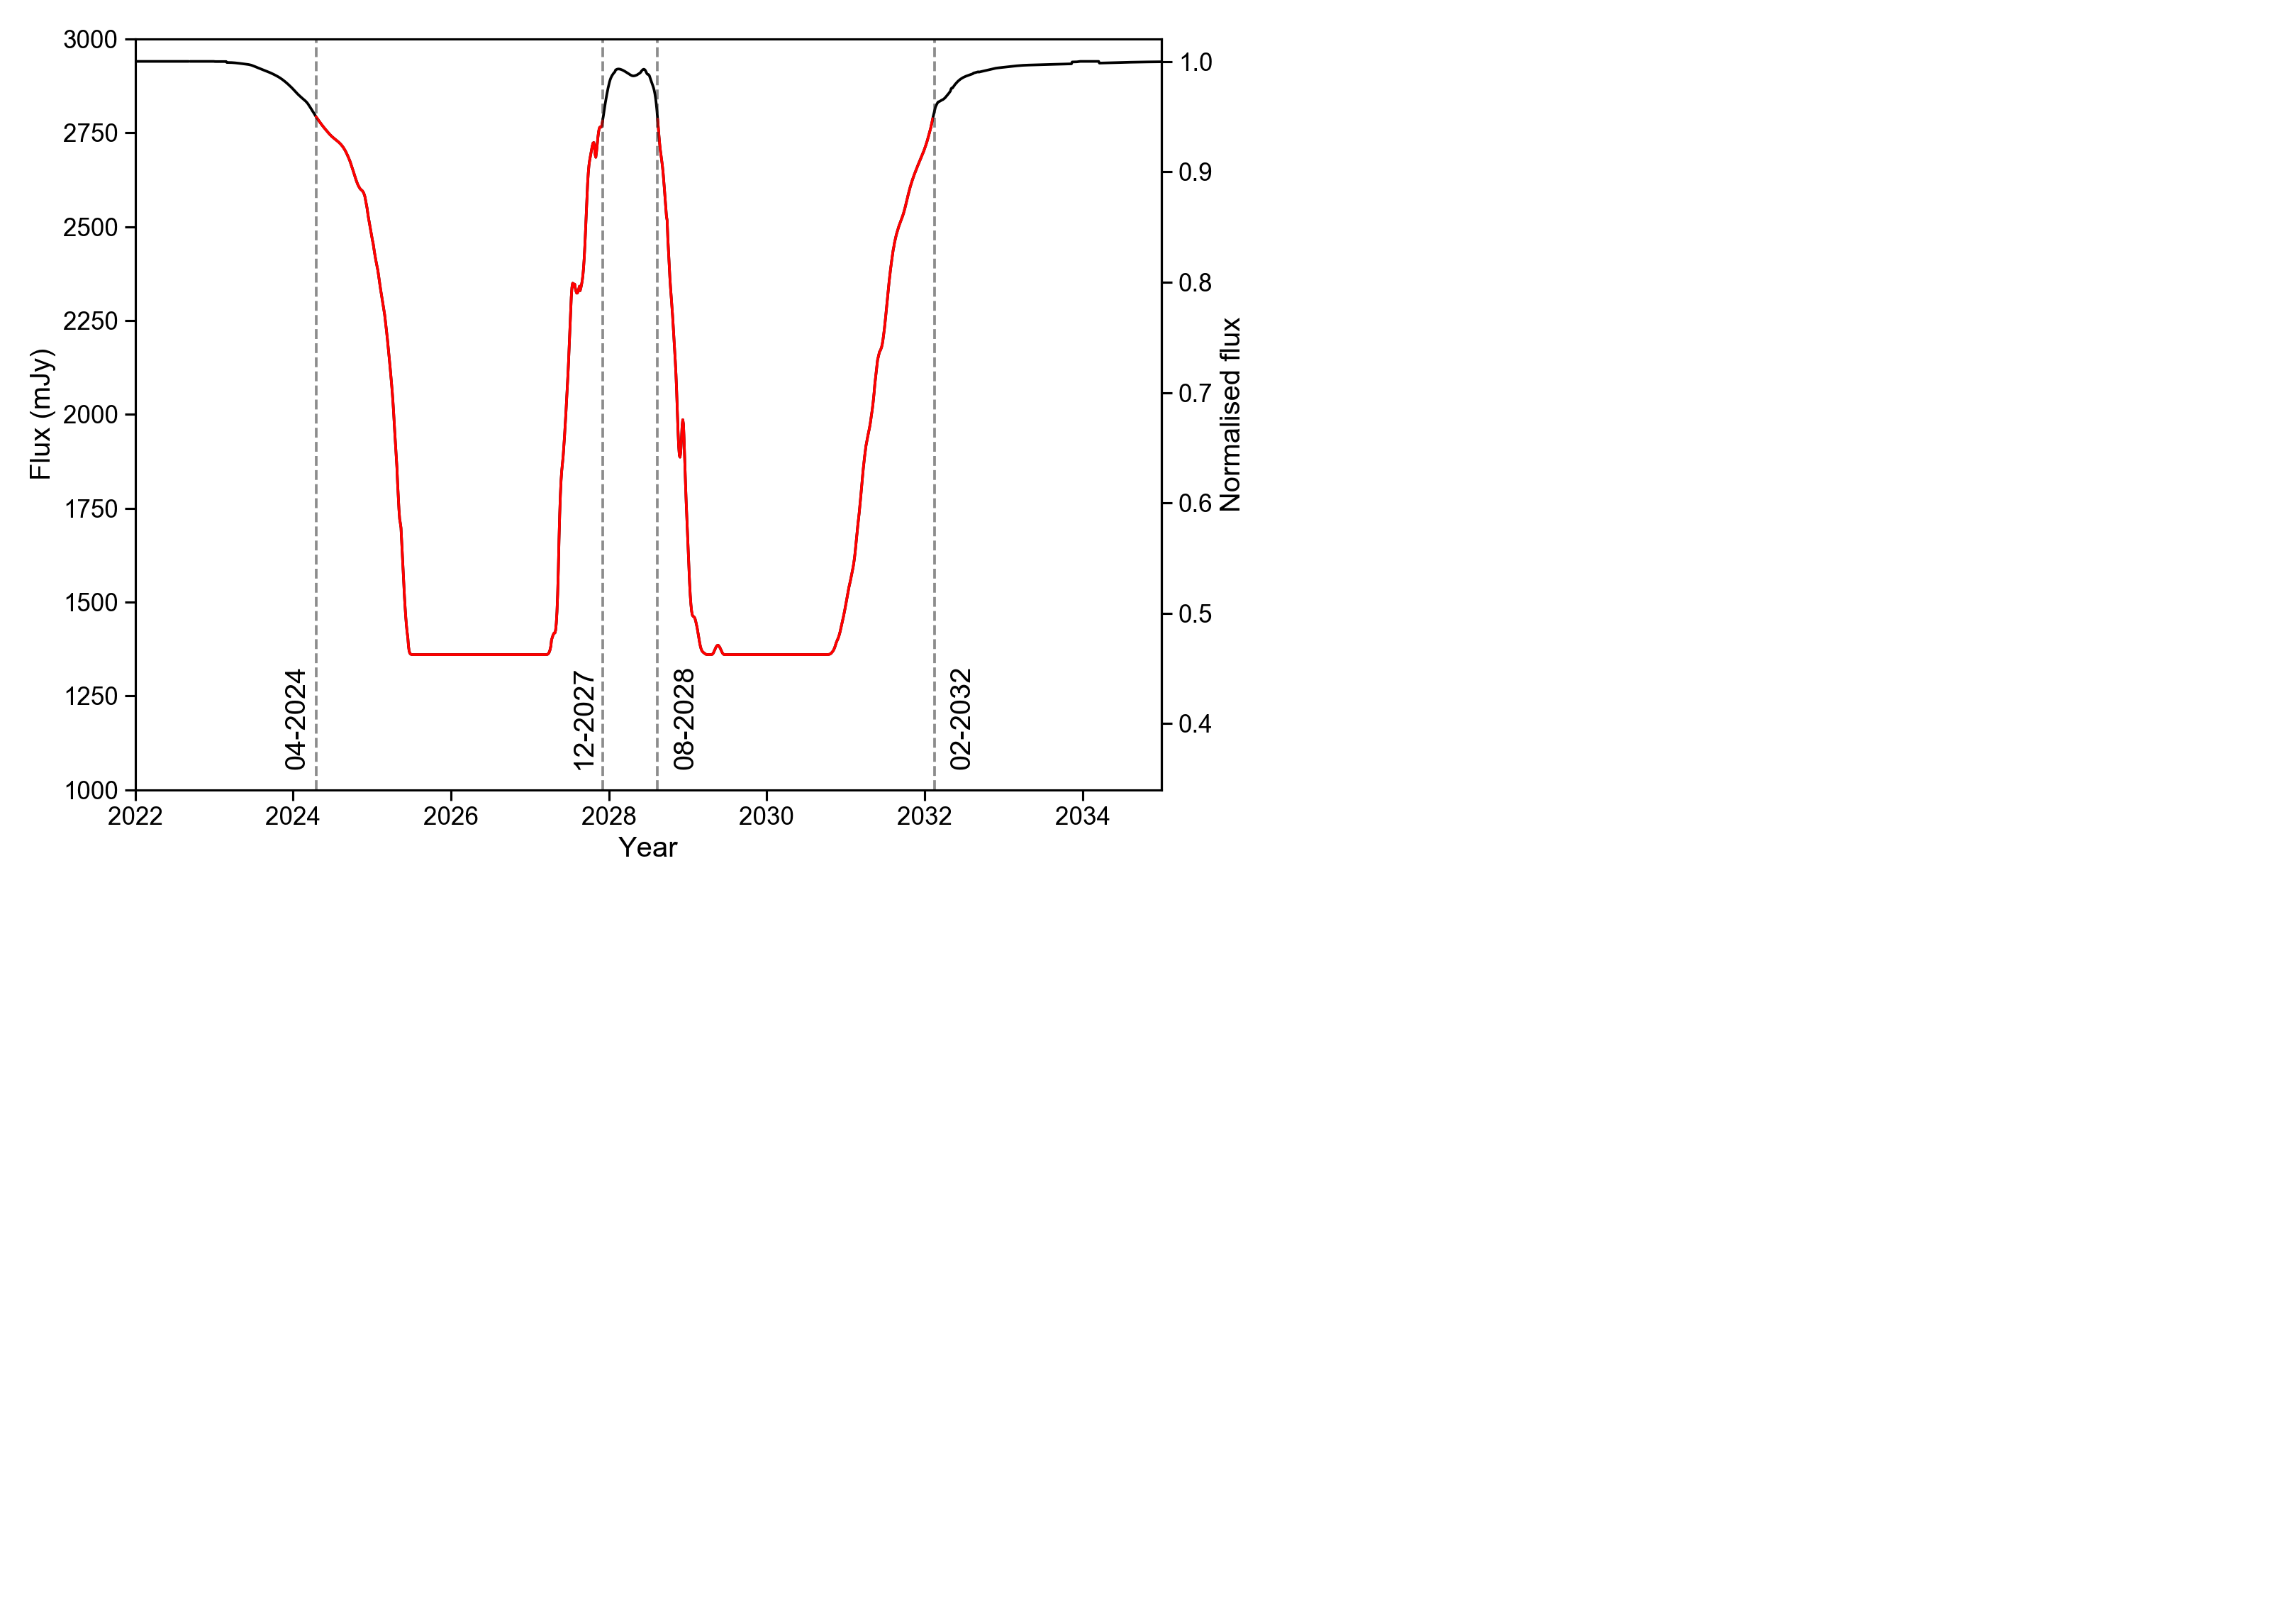

In [21]:
fig, ax = plt.subplots(1, figsize=(10,7))

f_tot = f0_Aa*np.exp(-tau_Aa) + f0_Ab*np.exp(-tau_Ab) + f_B
t_year = time.Time(t_ref - (40*P_B) + (times)*365.25, format='mjd').decimalyear
# t_year = time.Time(t_ref - (420000) + (times)*365.25, format='mjd').decimalyear

ax.plot(t_year, f_tot, color='black')
ax.set_ylabel('Flux (mJy)')
ax.set_xlabel('Year')
ax.set_ylim(1000,3000)

f_norm = lambda f: f/(f_A+f_B)
f_denorm = lambda f: f*(f_A+f_B)

threshold = 0.95
t_year_transit = t_year.copy()
t_year_transit[f_tot > threshold*(f_A+f_B)] =  np.nan
f_tot_transit = f_tot.copy()
f_tot_transit[f_tot > threshold*(f_A+f_B)] = np.nan

f_tot1 = f_tot[t_year < 2028.3]
f_tot2 = f_tot[t_year > 2028.3]
t_year1 = t_year[t_year < 2028.3]
t_year2 = t_year[t_year > 2028.3]

t_year1[f_tot1 > threshold*(f_A+f_B)] = np.nan
f_tot1[f_tot1 > threshold*(f_A+f_B)] = np.nan
t_year2[f_tot2 > threshold*(f_A+f_B)] = np.nan
f_tot2[f_tot2 > threshold*(f_A+f_B)] = np.nan

i_t1_start = np.nanargmin(t_year1)
i_t1_end = np.nanargmax(t_year1)
i_t2_start = np.nanargmin(t_year2)
i_t2_end = np.nanargmax(t_year2)

# print(times[i_t1_start]*2*np.pi/0.05416)
# print(times[i_t1_end]*2*np.pi/0.05416)
# print(times[len(f_tot1)+i_t2_start]*2*np.pi/0.05416)
# print(times[len(f_tot1)+i_t2_end]*2*np.pi/0.05416)

ax.plot(t_year_transit, f_tot_transit, color='red')
ax.set_xlim(np.ceil(min(t_year))+2, np.floor(max(t_year)))

# ax.scatter(t_year1[i_t1_start], f_tot1[i_t1_start], color='red')
# ax.scatter(t_year1[i_t1_end], f_tot1[i_t1_end], color='red')
# ax.scatter(t_year2[i_t2_start], f_tot2[i_t2_start], color='red')
# ax.scatter(t_year2[i_t2_end], f_tot2[i_t2_end], color='red')


ax.axvline(2024.29, linestyle='--', color='k', alpha=0.5)
plt.text(2024.29-0.4,1070, month_year_date(2024.29),rotation=90)
ax.axvline(t_year1[i_t1_end], linestyle='--', color='k', alpha=0.5)
plt.text(t_year1[i_t1_end]-0.4,1070, month_year_date(t_year1[i_t1_end]),rotation=90)
ax.axvline(t_year2[i_t2_start], linestyle='--', color='k', alpha=0.5)
plt.text(t_year2[i_t2_start]+0.2,1070, month_year_date(t_year2[i_t2_start]),rotation=90)
ax.axvline(2032.12, linestyle='--', color='k', alpha=0.5)
plt.text(2032.12+0.2,1070, month_year_date(2032.12),rotation=90)
ax.tick_params(axis='both', which='major', labelsize=14)
secax0 = ax.secondary_yaxis(location='right', functions=(f_norm, f_denorm))
secax0.tick_params(axis='both', which='major', labelsize=14)

secax0.set_ylabel('Normalised flux')
plt.savefig('LC_transit_dates.png')
# plt.title(f'{sim}')


plt.tight_layout()


In [ ]:
# Calculate flux ratio of 0.8/0.5um

fig, ax = plt.subplots(2, 1, figsize=(8,8), sharex=True)

sim = 'hd98800_30m_transit'
dm = 0.33

data_05 = np.loadtxt(f'tau_{sim}_{dm}_0.5um.txt')
data_08 = np.loadtxt(f'tau_{sim}_{dm}_0.8um.txt')

times = data_05[:,0]
tau_Aa_05 = data_05[:,1]
tau_Ab_05 = data_05[:,2]
tau_Aa_08 = data_08[:,1]
tau_Ab_08 = data_08[:,2]
t_year = time.Time(t_ref - (40*P_B) + (times)*365.25, format='mjd').decimalyear


# Fluxes at 0.8um and 0.5um
f_A_08, f_B_08, f0_Aa_08,f0_Ab_08 = interpolate_flux(0.8)
f_A_05, f_B_05, f0_Aa_05, f0_Ab_05 = interpolate_flux(0.5)
print(f_A_08, f_B_08, f_A_05, f_B_05)

f_08 = (f0_Aa_08*np.exp(-tau_Aa_08)) + (f0_Ab_08*np.exp(-tau_Ab_08)) + f_B_08
f_05 = (f0_Aa_05*np.exp(-tau_Aa_05)) + (f0_Ab_05*np.exp(-tau_Ab_05)) + f_B_05 

ax[0,].plot(t_year, 2.5*np.log10(f_08/f_05), color='black')
ax[0,].set_ylabel('V - I')
ax[0,].set_xlim(np.ceil(min(t_year))+2, np.floor(max(t_year)))
ax[1,].set_xlim(np.ceil(min(t_year))+2, np.floor(max(t_year)))


ax[1,].plot(t_year, f_08, color='red', label='I Band (0.8 $\mu m$)')
ax[1,].plot(t_year, f_05, color='blue', label='V Band (0.5 $\mu m$)')
ax[1,].set_ylabel('Flux (mJy)')
ax[1,].set_xlabel('Year')
ax[1,].legend(loc='center right')
# ax[1,].set_ylim(0,3100)

fig.tight_layout()

# plot Aa and Ab LCs  in panels above/below 


In [ ]:
fig, ax = plt.subplots(1, figsize=(10,7))

f_A, f_B, f0_Aa, f0_Ab = interpolate_flux(0.8)

data_alpha_005= np.loadtxt(f'tau_hd98800_30m_transit_0.33_0.8um.txt')
data_alpha_01 = np.loadtxt(f'tau_alpha_1e-2_transit_0.33_0.8um_v2.txt')
data_alpha_05 = np.loadtxt(f'tau_alpha_5e-2_0.33_0.8um.txt')

times = data_alpha_005[:,0]
tau_Aa_005 = data_alpha_005[:,1]
tau_Ab_005 = data_alpha_005[:,2]
tau_Aa_01 = data_alpha_01[:,1]
tau_Ab_01 = data_alpha_01[:,2]
tau_Aa_05 = data_alpha_05[:,1]
tau_Ab_05 = data_alpha_05[:,2]


f_tot_005 = f0_Aa*np.exp(-tau_Aa_005) + f0_Ab*np.exp(-tau_Ab_005) + f_B
f_tot_01 = f0_Aa*np.exp(-tau_Aa_01) + f0_Ab*np.exp(-tau_Ab_01) + f_B
f_tot_05 = f0_Aa*np.exp(-tau_Aa_05) + f0_Ab*np.exp(-tau_Ab_05) + f_B
t_year = time.Time(t_ref - (40*P_B) + (times)*365.25, format='mjd').decimalyear

ax.plot(t_year, f_tot_005,   label="$\\alpha$=0.005", alpha=0.7, c='hotpink')
ax.plot(t_year, f_tot_01, label="$\\alpha$=0.01", alpha=0.7, c='navy')
ax.plot(t_year, f_tot_05, label="$\\alpha$=0.05", alpha=0.7, c='green')
ax.set_ylabel('Flux (mJy)')
ax.set_xlabel('Year')
ax.set_xlim(np.ceil(min(t_year))+1, (max(t_year)))
# print(np.ceil(min(t_year)))

f_norm = lambda f: f/(f_A+f_B)
f_denorm = lambda f: f*(f_A+f_B)


secax0 = ax.secondary_yaxis(location='right', functions=(f_norm, f_denorm))
secax0.set_ylabel('Normalised flux')

ax.legend(prop={'size': 14})

plt.tight_layout()


In [ ]:
fig, ax = plt.subplots(1, figsize=(10,7))

f_A, f_B, f0_Aa, f0_Ab = interpolate_flux(0.8)

data_alpha_0033= np.loadtxt(f'tau_hd98800_30m_transit_0.033_0.8um.txt')
data_alpha_033 = np.loadtxt(f'tau_hd98800_30m_transit_0.33_0.8um.txt')
data_alpha_33 = np.loadtxt(f'tau_hd98800_30m_transit_3.3_0.8um.txt')

times = data_alpha_0033[:,0]
tau_Aa_0033 = data_alpha_0033[:,1]
tau_Ab_0033 = data_alpha_0033[:,2]
tau_Aa_033 = data_alpha_033[:,1]
tau_Ab_033 = data_alpha_033[:,2]
tau_Aa_33 = data_alpha_33[:,1]
tau_Ab_33 = data_alpha_33[:,2]


f_tot_0033 = f0_Aa*np.exp(-tau_Aa_0033) + f0_Ab*np.exp(-tau_Ab_0033) + f_B
f_tot_033 = f0_Aa*np.exp(-tau_Aa_033) + f0_Ab*np.exp(-tau_Ab_033) + f_B
f_tot_33 = f0_Aa*np.exp(-tau_Aa_33) + f0_Ab*np.exp(-tau_Ab_33) + f_B
t_year = time.Time(t_ref - (40*P_B) + (times)*365.25, format='mjd').decimalyear

ax.plot(t_year, f_tot_0033,   label="$M_{dust}$=0.033 $M_{{\oplus}}$", alpha=0.7, c='hotpink')
ax.plot(t_year, f_tot_033, label="$M_{dust}$=0.33 $M_{{\oplus}}$", alpha=0.7, c='navy')
ax.plot(t_year, f_tot_33, label="$M_{dust}$=3.3 $M_{{\oplus}}$", alpha=0.7, c='green')
ax.set_ylabel('Flux (mJy)')
ax.set_xlabel('Year')
ax.set_xlim(np.ceil(min(t_year))+2, (max(t_year)))
# print(np.ceil(min(t_year)))

f_norm = lambda f: f/(f_A+f_B)
f_denorm = lambda f: f*(f_A+f_B)


secax0 = ax.secondary_yaxis(location='right', functions=(f_norm, f_denorm))
secax0.set_ylabel('Normalised flux')

ax.legend(prop={'size': 14})

plt.tight_layout()


In [ ]:
fig, ax = plt.subplots(1, figsize=(10,7))

f_A, f_B, f0_Aa, f0_Ab = interpolate_flux(0.8)

# data_alpha_3= np.loadtxt(f'tau_hd98800_3m_redo_0.33_0.8um_v2.txt')
data_alpha_33 = np.loadtxt(f'tau_hd98800_30m_transit_0.33_0.8um.txt')
data_alpha_330 = np.loadtxt(f'tau_hd98800_300m_transit_0.33_0.8um.txt')

times = data_alpha_33[:,0]
# tau_Aa_3 = data_alpha_3[:,1]
# tau_Ab_3 = data_alpha_3[:,2]
tau_Aa_33 = data_alpha_33[:,1]
tau_Ab_33 = data_alpha_33[:,2]
tau_Aa_330 = data_alpha_330[:,1]
tau_Ab_330 = data_alpha_330[:,2]


# f_tot_3 = f0_Aa*np.exp(-tau_Aa_3) + f0_Ab*np.exp(-tau_Ab_3) + f_B
f_tot_33 = f0_Aa*np.exp(-tau_Aa_33) + f0_Ab*np.exp(-tau_Ab_33) + f_B
f_tot_330 = f0_Aa*np.exp(-tau_Aa_330) + f0_Ab*np.exp(-tau_Ab_330) + f_B
t_year = time.Time(t_ref - (40*P_B) + (times)*365.25, format='mjd').decimalyear

# ax.plot(t_year, f_tot_3, label='$M_{gas}$=3.3 $M_{{\oplus}}$', alpha=0.7, c='maroon')
ax.plot(t_year, f_tot_33, label='$M_{gas}$=33 $M_{{\oplus}}$', alpha=0.6, c='navy') 
ax.plot(t_year, f_tot_330, label='$M_{gas}$=330 $M_{{\oplus}}$', alpha=0.8, c='hotpink')
ax.set_ylabel('Flux (mJy)')
ax.set_xlabel('Year')
ax.set_xlim(np.ceil(min(t_year))+1, (max(t_year)))
# print(np.ceil(min(t_year)))

f_norm = lambda f: f/(f_A+f_B)
f_denorm = lambda f: f*(f_A+f_B)


secax0 = ax.secondary_yaxis(location='right', functions=(f_norm, f_denorm))
secax0.set_ylabel('Normalised flux')
plt.legend(prop={'size': 14})

plt.tight_layout()


In [ ]:
# All comparison
fig, ax = plt.subplots(1, figsize=(10,5))

f_A, f_B, f0_Aa, f0_Ab = interpolate_flux(0.8)

data_ref = np.loadtxt('tau_hd98800_30m_transit_0.33_0.8um.txt')
data_highdm = np.loadtxt('tau_hd98800_30m_transit_3.3_0.8um.txt')
data_highgm = np.loadtxt('tau_hd98800_300m_transit_0.33_0.8um.txt')
data_highalpha = np.loadtxt('tau_alpha_5e-2_0.33_0.8um.txt')
data_longsim = np.loadtxt('tau_longsim_0.33_0.8um.txt')


times = data_ref[:,0]
times_longsim = data_longsim[:,0]

tau_Aa_ref = data_ref[:,1]
tau_Ab_ref = data_ref[:,2]
tau_Aa_highdm = data_highdm[:,1]
tau_Ab_highdm = data_highdm[:,2]
tau_Aa_highgm = data_highgm[:,1]
tau_Ab_highgm = data_highgm[:,2]
tau_Aa_highalpha = data_highalpha[:,1]
tau_Ab_highalpha = data_highalpha[:,2]
tau_Aa_longsim = data_longsim[:,1]
tau_Ab_longsim = data_longsim[:,2]


f_tot_ref = f0_Aa*np.exp(-tau_Aa_ref) + f0_Ab*np.exp(-tau_Ab_ref) + f_B
f_tot_highdm = f0_Aa*np.exp(-tau_Aa_highdm) + f0_Ab*np.exp(-tau_Ab_highdm) + f_B
f_tot_highgm = f0_Aa*np.exp(-tau_Aa_highgm) + f0_Ab*np.exp(-tau_Ab_highgm) + f_B
f_tot_highalpha = f0_Aa*np.exp(-tau_Aa_highalpha) + f0_Ab*np.exp(-tau_Ab_highalpha) + f_B
f_tot_longsim = f0_Aa*np.exp(-tau_Aa_longsim) + f0_Ab*np.exp(-tau_Ab_longsim) + f_B
t_year = time.Time(t_ref - (40*P_B) + (times)*365.25, format='mjd').decimalyear
t_year_longsim = time.Time(t_ref - (420000) + (times_longsim)*365.25, format='mjd').decimalyear

CB_colors = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

ax.plot(t_year, f_tot_ref,   label="Reference", alpha=0.9, c='white', linewidth=2.3)
ax.plot(t_year, f_tot_highdm, label="High $M_{dust}$", alpha=0.9, linestyle='--', c='tomato', linewidth=2.3)
ax.plot(t_year, f_tot_highgm, label="High $M_{gas}$", alpha=0.7, linestyle='--', c='cyan', linewidth=2.3)
ax.plot(t_year, f_tot_highalpha, label="High $\\alpha$", alpha=0.9, linestyle='--', c='pink', linewidth=2.3)
ax.plot(t_year_longsim, f_tot_longsim, label="Outer binary", alpha=1, linestyle='--', c='sandybrown', linewidth=2.3)
ax.set_ylabel('Flux (mJy)')
ax.set_xlabel('Year')
ax.set_xlim(np.ceil(min(t_year))+1, (max(t_year_longsim)))
# print(np.ceil(min(t_year)))

f_norm = lambda f: f/(f_A+f_B)
f_denorm = lambda f: f*(f_A+f_B)
print(f_A+f_B)

secax0 = ax.secondary_yaxis(location='right', functions=(f_norm, f_denorm))
secax0.set_ylabel('Normalised flux')

leg = ax.legend(prop={'size': 14})
leg.set_alpha(0.4)
plt.tick_params(axis='both', which='major', labelsize=16)
secax0.set_yticklabels([0.4,0.5,0.6,0.7,0.8,0.9,1.0], size=16)


plt.tight_layout()



<IPython.core.display.Javascript object>


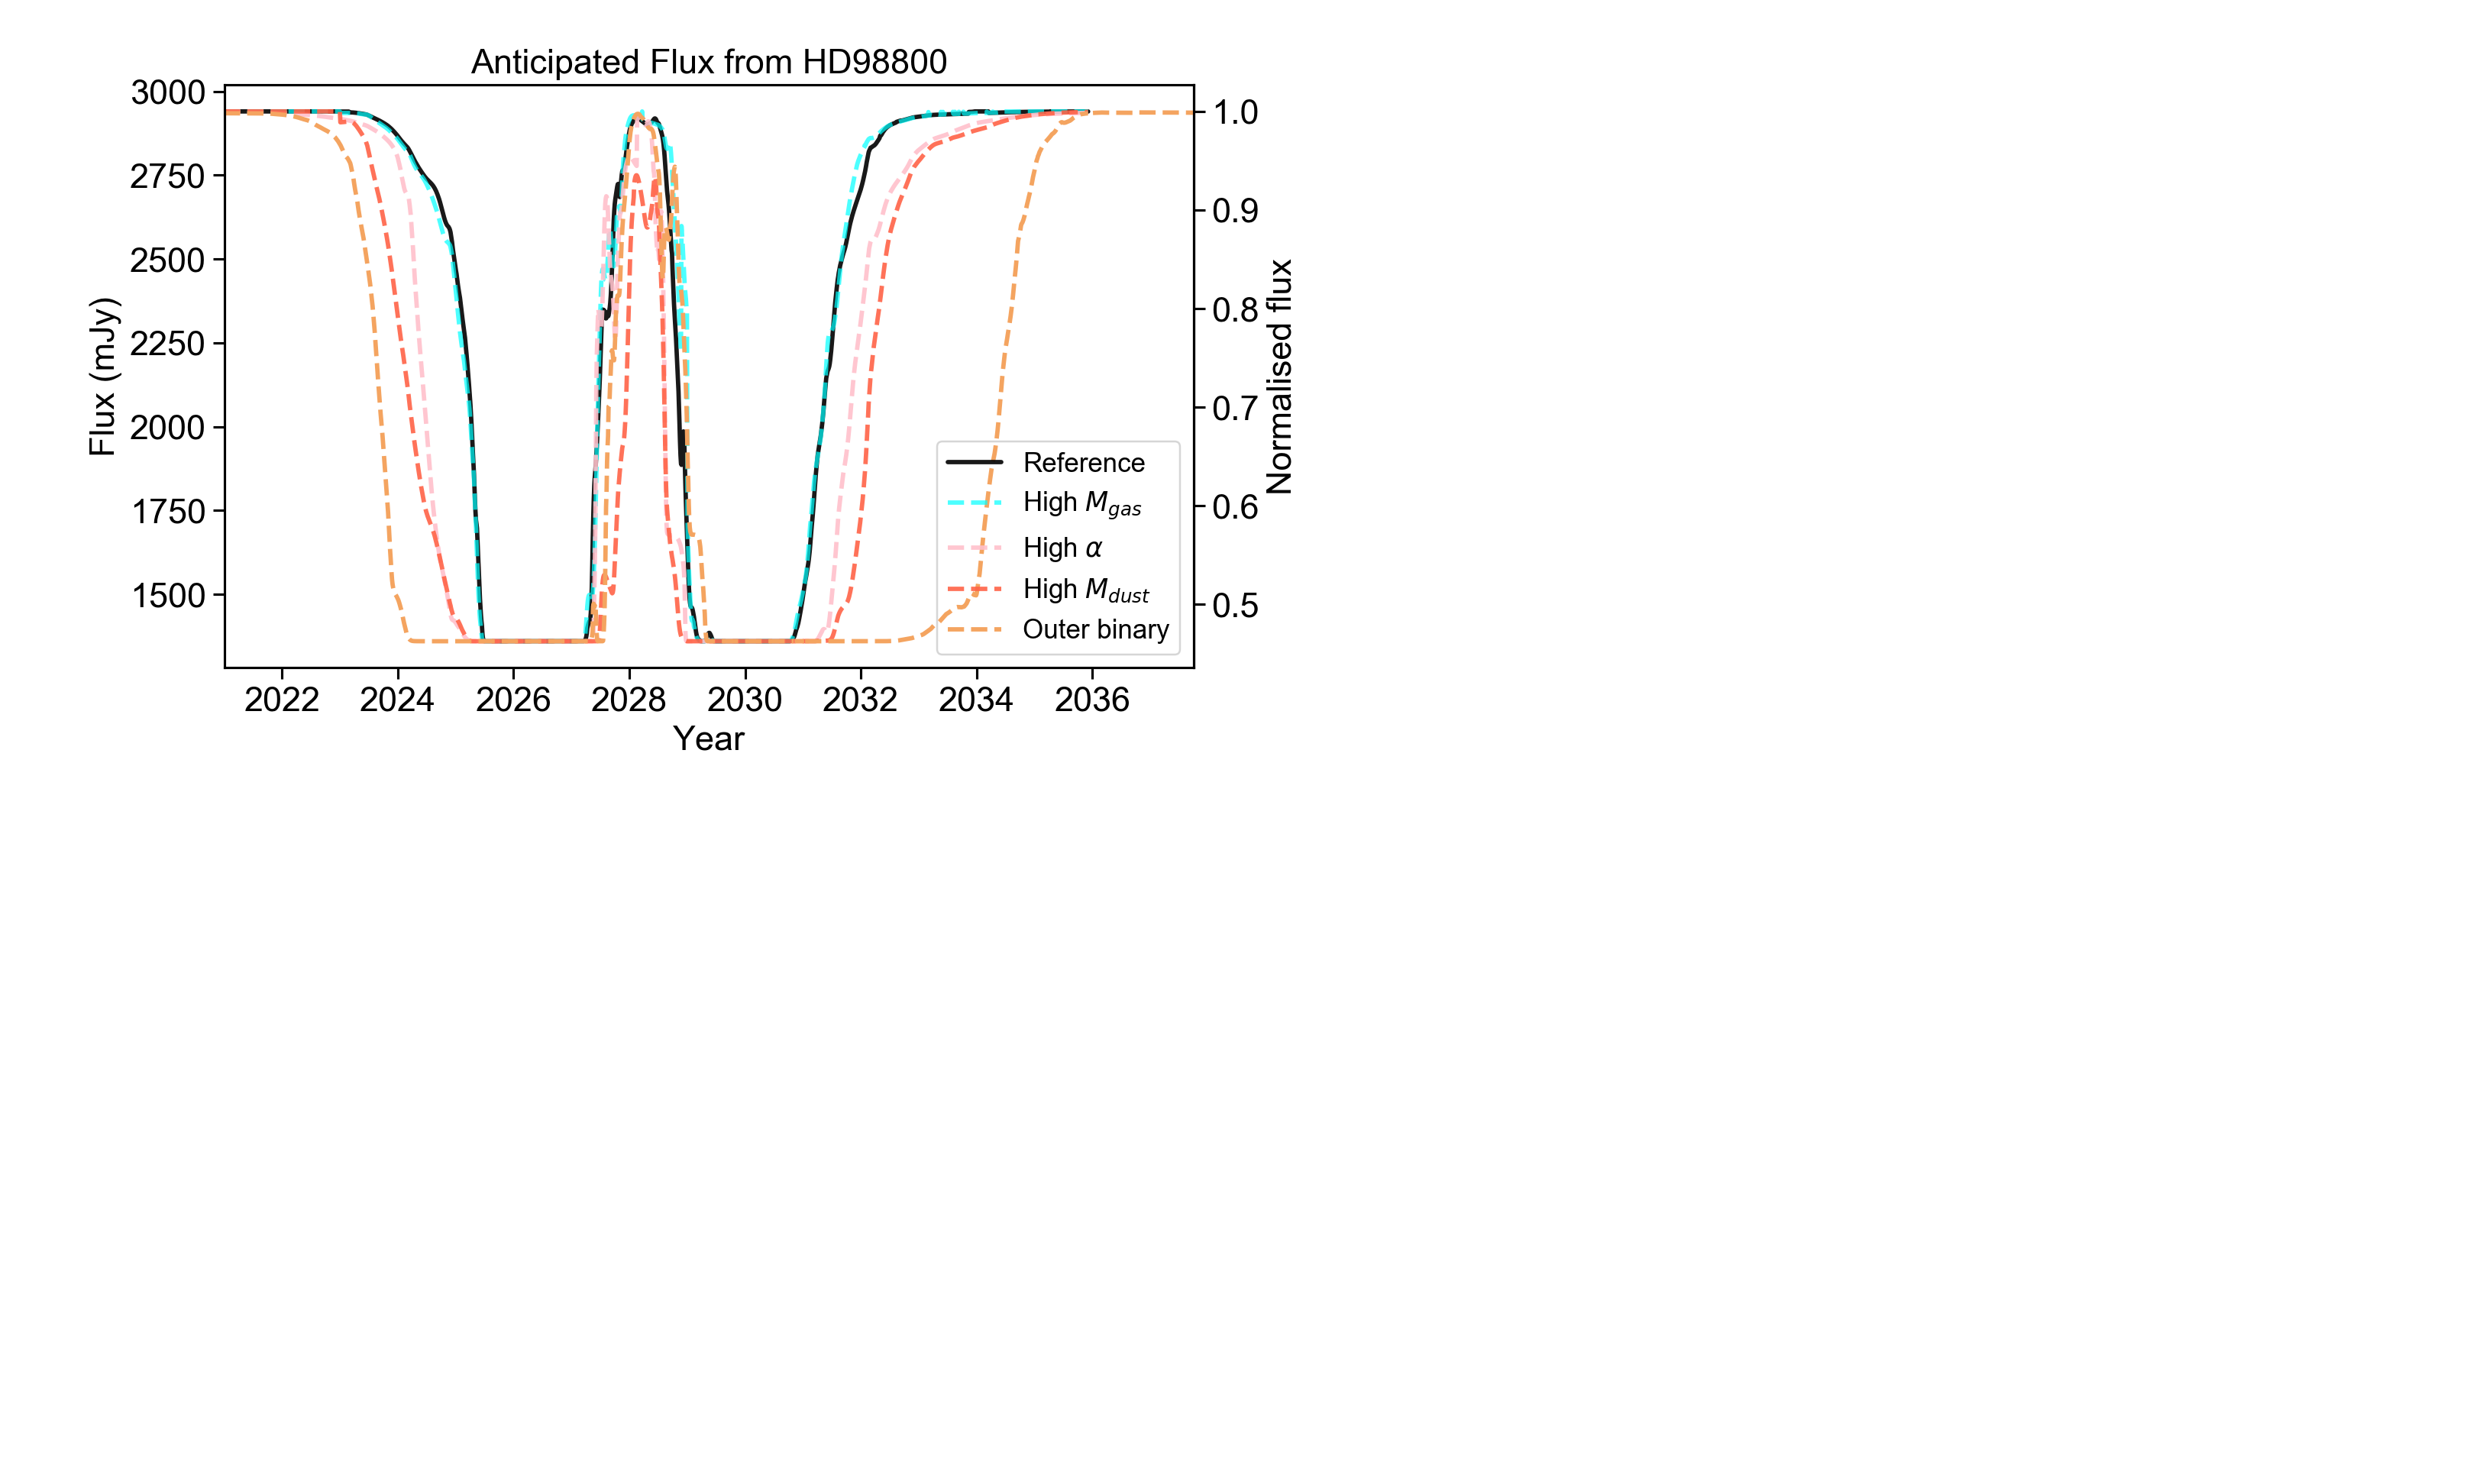

/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator


In [14]:
# All comparison
fig, ax = plt.subplots(1, figsize=(10,6))

f_A, f_B, f0_Aa, f0_Ab = interpolate_flux(0.8)

data_ref = np.loadtxt('tau_hd98800_30m_transit_0.33_0.8um.txt')
data_highdm = np.loadtxt('tau_hd98800_30m_transit_3.3_0.8um.txt')
data_highgm = np.loadtxt('tau_hd98800_300m_transit_0.33_0.8um.txt')
data_highalpha = np.loadtxt('tau_alpha_5e-2_0.33_0.8um.txt')
data_longsim = np.loadtxt('tau_longsim_0.33_0.8um.txt')

data_list = [data_ref, data_highdm, data_highgm, data_highalpha, data_longsim]

times = data_ref[:,0]
times_longsim = data_longsim[:,0]

tau_Aa_ref = data_ref[:,1]
tau_Ab_ref = data_ref[:,2]
tau_Aa_highdm = data_highdm[:,1]
tau_Ab_highdm = data_highdm[:,2]
tau_Aa_highgm = data_highgm[:,1]
tau_Ab_highgm = data_highgm[:,2]
tau_Aa_highalpha = data_highalpha[:,1]
tau_Ab_highalpha = data_highalpha[:,2]
tau_Aa_longsim = data_longsim[:,1]
tau_Ab_longsim = data_longsim[:,2]


f_tot_ref = f0_Aa*np.exp(-tau_Aa_ref) + f0_Ab*np.exp(-tau_Ab_ref) + f_B
f_tot_highdm = f0_Aa*np.exp(-tau_Aa_highdm) + f0_Ab*np.exp(-tau_Ab_highdm) + f_B
f_tot_highgm = f0_Aa*np.exp(-tau_Aa_highgm) + f0_Ab*np.exp(-tau_Ab_highgm) + f_B
f_tot_highalpha = f0_Aa*np.exp(-tau_Aa_highalpha) + f0_Ab*np.exp(-tau_Ab_highalpha) + f_B
f_tot_longsim = f0_Aa*np.exp(-tau_Aa_longsim) + f0_Ab*np.exp(-tau_Ab_longsim) + f_B

t_year = time.Time(t_ref - (40*P_B) + (times)*365.25, format='mjd').decimalyear
t_year_longsim = time.Time(t_ref - (420000) + (times_longsim)*365.25, format='mjd').decimalyear

CB_colors = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']


ax.plot(t_year, f_tot_ref,   label="Reference", alpha=0.9, c='black', linewidth=2.3)

f_norm = lambda f: f/(f_A+f_B)
f_denorm = lambda f: f*(f_A+f_B)
secax0 = ax.secondary_yaxis(location='right', functions=(f_norm, f_denorm))
secax0.set_ylabel('Normalised flux')
leg = ax.legend(loc='lower right', prop={'size': 14})
leg.set_alpha(0.4)
plt.tick_params(axis='both', which='major', labelsize=18)
secax0.set_yticklabels([0.4,0.5,0.6,0.7,0.8,0.9,1.0], size=18)
ax.set_ylabel('Flux (mJy)')
ax.set_xlabel('Year')
ax.set_xlim(np.ceil(min(t_year))+1, (max(t_year_longsim)))
plt.savefig('LC1.png', dpi=150)

ax.plot(t_year, f_tot_highgm, label="High $M_{gas}$", alpha=0.7, linestyle='--', c='cyan', linewidth=2.3)
leg = ax.legend(loc='lower right', prop={'size': 14})
leg.set_alpha(0.4)
plt.savefig('LC2.png', dpi=150)


ax.plot(t_year, f_tot_highalpha, label="High $\\alpha$", alpha=0.9, linestyle='--', c='pink', linewidth=2.3)
leg = ax.legend(loc='lower right', prop={'size': 14})
leg.set_alpha(0.4)
plt.savefig('LC3.png', dpi=150)

ax.plot(t_year, f_tot_highdm, label="High $M_{dust}$", alpha=0.9, linestyle='--', c='tomato', linewidth=2.3)
leg = ax.legend(loc='lower right', prop={'size': 14})
leg.set_alpha(0.4)
plt.savefig('LC4.png', dpi=150)


ax.plot(t_year_longsim, f_tot_longsim, label="Outer binary", alpha=1, linestyle='--', c='sandybrown', linewidth=2.3)
leg = ax.legend(loc='lower right', prop={'size': 14})
leg.set_alpha(0.4)
plt.title('Anticipated Flux from HD98800')

# print(np.ceil(min(t_year)))
plt.savefig('LC5.png', dpi=150)




plt.tight_layout()



In [ ]:
# Plot tilt vs time
fig, ax = plt.subplots(1, figsize=(10,5))


sim = 'longsim'
angm_files = np.concatenate((np.arange(201,1001,10), np.arange(1133,2701,133)))

columns = ['radius', 'sigma', '<h>/H', 'lx', 'ly', 'lz', 'tilt', 'twist', 'psi', 'H/R', '|e|']

times = []
tilts = []

for angm_file in angm_files:
    file_no = str(angm_file).rjust(5, '0')
    file = f"{sim}/angm" + file_no
    t = float(open(file).readline().split()[-1])/(2*np.pi*0.863)    # [B binary orbits]
    try:
        data = pd.read_csv(file, sep='\s+', skiprows=[0,1], engine='python', names=[columns[i] for i in range(11)])
        avg_tilt = np.median(data['tilt'])
        times.append(t)
        tilts.append(180-((avg_tilt*180/np.pi)+26))
    except:
        times.append(np.nan)
        tilts.append(np.nan)

# ax.plot(times,tilts)
dtiltdt = np.diff(tilts)/np.diff(np.array(times)/0.863)
ax.plot(times[:-1], dtiltdt)
ax.axvline(67+(267*1), linestyle='--', color='k', alpha=0.5)
ax.axvline(67+(267*2), linestyle='--', color='k', alpha=0.5)
ax.axvline(67+(267*3), linestyle='--', color='k', alpha=0.5)
ax.axvline(67+(267*4), linestyle='--', color='k', alpha=0.5)
ax.set_xticks(np.arange(200,1401,100))
# ax.set_xlim(270, 1300)
# ax.set_ylim(89,95)
ax.set_ylabel('Tilt (deg)')
ax.set_xlabel('$t$/$t_{orb}$')
print(np.diff(tilts))



In [ ]:
# Compare same gas mass, wavelength and alpha at different dust masses

%matplotlib notebook

sim = 'hd98800_30m_transit'
wl = 0.8
dms = [0.033, 0.33, 3.3]

data0 = np.loadtxt(f'tau_{sim}_{str(dms[0])}_0.8um.txt')
data1 = np.loadtxt(f'tau_{sim}_{str(dms[1])}_0.8um.txt')
data2 = np.loadtxt(f'tau_{sim}_{str(dms[2])}_0.8um.txt')

times = data0[:,0]
tau_Aa0 = data0[:,1]
tau_Ab0 = data0[:,2]
tau_Aa1 = data1[:,1][400:]
tau_Ab1 = data1[:,2][400:]
tau_Aa2 = data2[:,1]
tau_Ab2 = data2[:,2]

f0_Aa = (0.87/(0.87+0.13))*2000
f0_Ab = (0.13/(0.87+0.13))*2000
f_Aa0 = (f0_Aa*np.exp(-tau_Aa0))
f_Ab0 = (f0_Ab*np.exp(-tau_Ab0))
f_Aa1 = (f0_Aa*np.exp(-tau_Aa1))
f_Ab1 = (f0_Ab*np.exp(-tau_Ab1))
f_Aa2 = (f0_Aa*np.exp(-tau_Aa2))
f_Ab2 = (f0_Ab*np.exp(-tau_Ab2))

fig,ax = plt.subplots(2,1, figsize=(6,10))

# ax[0].plot(times, f_Aa0, label='$M_{dust}$ = 0.033 $M_{{\oplus}}$')
# ax[0].plot(times, f_Aa1, label='$M_{dust}$ = 0.33 $M_{{\oplus}}$')
ax[0].plot(times, f_Aa2, label='$M_{dust}$ = 3.3 $M_{{\oplus}}$')
ax[0].plot(times, f0_Aa*np.exp(-tau_Aa))
ax[0].legend(loc='right')

# ax[1].plot(times, f_Ab0, label='$M_{dust}$ = 0.033 $M_{{\oplus}}$')
# ax[1].plot(times, f_Ab1, label='$M_{dust}$ = 0.33 $M_{{\oplus}}$')
ax[1].plot(times, f_Ab2, label='$M_{dust}$ = 3.3 $M_{{\oplus}}$')
ax[1].plot(times, f0_Ab*np.exp(-tau_Ab))

ax[1].legend(loc='right')


In [ ]:
fig,ax = plt.subplots(3,2, figsize=(6,10))
sim = 'hd98800'
dms =  [0.033, 0.33, 3.3]

f_Aa = (0.87/(0.87+0.13))*2300
f_Ab = (0.13/(0.87+0.13))*2300


def get_disc_edges(taus, times, tau_ot=1):
    tau_ot_indices = []
    for i,t in enumerate(taus):
        if (t > 1 and taus[i-1] <= 1) or (t <= 1 and taus[i-1] > 1):
            tau_ot_indices.append(i)
    
    tau_ot_indices = np.array(tau_ot_indices)
#     edge1_indices = []
#     for tau in tau_ot_indices:
        
    print(tau_ot_indices)
    return times[tau_ot_indices]
    

for i,dm in enumerate(dms):
    data = np.loadtxt(f'tau_{sim}_{str(dm)}.txt')
    times = data[:,0]
    tau_Aa = data[:,1]
    tau_Ab = data[:,2]
    x_Aas = data[:,3]
    y_Aas = data[:,4]
    x_Abs = data[:,5]
    y_Abs = data[:,6]

    ax[i,0].plot(times, f_Aa*np.exp(-tau_Aa), alpha=0.7)
    ax[i,1].plot(times, f_Ab*np.exp(-tau_Ab), alpha=0.7)
    ax[i,0].set_title(f'Aa, $M_{{dust}}$ = {dm} $M_{{\oplus}}$')
    ax[i,1].set_title(f'Ab $M_{{dust}}$ = {dm} $M_{{\oplus}}$')
    ax[i,0].set_ylabel('Flux (mJy)')
    ax[i,0].set_xlabel('Time (yrs)')

    disc_edge_times_Aa = get_disc_edges(tau_Aa, times)
    disc_edge_times_Ab = get_disc_edges(tau_Ab, times)
    ax[i,0].vlines(disc_edge_times_Aa, ymin=0, ymax=2000, color='black', linestyles='dashed')
    ax[i,1].vlines(disc_edge_times_Ab, ymin=0, ymax=300, color='black', linestyles='dashed')
    
plt.tight_layout()

In [ ]:
fig,ax = plt.subplots(3,2, figsize=(6,10))
sims = ['lowviscdisc','hd98800','highviscdisc']
alphas = [0.001, 0.005,  0.01]
dm =  0.033

f_Aa = (0.87/(0.87+0.13))*2300
f_Ab = (0.13/(0.87+0.13))*2300


for i,sim in enumerate(sims):
    data = np.loadtxt(f'tau_{sim}_{str(dm)}.txt')
    times = data[:,0]
    tau_Aa = data[:,1]
    tau_Ab = data[:,2]
    x_Aas = data[:,3]
    y_Aas = data[:,4]
    x_Abs = data[:,5]
    y_Abs = data[:,6]

    ax[i,0].plot(times, f_Aa*np.exp(-tau_Aa))
    ax[i,1].plot(times, f_Ab*np.exp(-tau_Ab))
    ax[i,0].set_title(f'Aa, $\\alpha$ = {alphas[i]}')
    ax[i,1].set_title(f'Ab, $\\alpha$ = {alphas[i]}')
    ax[i,0].set_ylabel('Flux (mJy)')
    ax[i,0].set_xlabel('Time (yrs)')
    ax[i,1].set_xlabel('Time (yrs)')

plt.tight_layout()

In [ ]:
fig,ax = plt.subplots(nrows=2, figsize=(5,7))
sims = ['lowviscdisc','hd98800','highviscdisc']
alphas = [0.001, 0.005,  0.01]
dm =  0.33

f_Aa = (0.87/(0.87+0.13))*2000
f_Ab = (0.13/(0.87+0.13))*2000


for i,sim in enumerate(sims):
    data = np.loadtxt(f'tau_{sim}_{str(dm)}.txt')
    times = data[:,0]
    tau_Aa = data[:,1]
    tau_Ab = data[:,2]
    x_Aas = data[:,3]
    y_Aas = data[:,4]
    x_Abs = data[:,5]
    y_Abs = data[:,6]

    ax[0].plot(times, f_Aa*np.exp(-tau_Aa), alpha=0.6, label='$\\alpha$ = '+str(alphas[i]))
    ax[1].plot(times, f_Ab*np.exp(-tau_Ab), alpha=0.6, label='$\\alpha$ = '+str(alphas[i]))
    ax[0].set_title(f'Aa ($M_{{dust}}$ = {dm}$M_{{\oplus}}$)')
    ax[1].set_title(f'Ab ($M_{{dust}}$ = {dm}$M_{{\oplus}}$)')
    ax[0].set_ylabel('Flux (mJy)')
    ax[1].set_ylabel('Flux (mJy)')
    ax[0].set_xlabel('Time (yrs)')
    ax[1].set_xlabel('Time (yrs)')

    ax[0].legend(prop={'size': 9})
    ax[1].legend(prop={'size': 9})

plt.tight_layout()

In [ ]:
fig,ax = plt.subplots(nrows=2, figsize=(4,6))
sims = ['lowviscdisc','hd98800','highviscdisc']
alphas = [0.001, 0.005,  0.01]
dm =  3.3

f_Aa = (0.87/(0.87+0.13))*2300
f_Ab = (0.13/(0.87+0.13))*2300

ref_data = np.loadtxt(f'tau_hd98800_{str(dm)}.txt')
tau_Aa_ref = ref_data[:,1]
tau_Ab_ref = ref_data[:,2]

f_Aa_ref  = f_Aa*np.exp(-tau_Aa_ref)/np.max(f_Aa*np.exp(-tau_Aa_ref))
f_Ab_ref  = f_Ab*np.exp(-tau_Ab_ref)/np.max(f_Ab*np.exp(-tau_Ab_ref))

for i,sim in enumerate(sims):
    data = np.loadtxt(f'tau_{sim}_{str(dm)}.txt')
    times = data[:,0]
    tau_Aa = data[:,1]
    tau_Ab = data[:,2]
    x_Aas = data[:,3]
    y_Aas = data[:,4]
    x_Abs = data[:,5]
    y_Abs = data[:,6]

    ax[0].plot(times, (f_Aa*np.exp(-tau_Aa)/np.max(f_Aa*np.exp(-tau_Aa)))-f_Aa_ref, alpha=0.6, label='$\\alpha$ = '+str(alphas[i]))
    ax[1].plot(times, (f_Ab*np.exp(-tau_Ab)/np.max(f_Ab*np.exp(-tau_Ab)))-f_Ab_ref, alpha=0.6, label='$\\alpha$ = '+str(alphas[i]))
    ax[0].set_title(f'Aa ($M_{{dust}}$ = {dm}$M_{{\oplus}}$)')
    ax[1].set_title(f'Ab ($M_{{dust}}$ = {dm}$M_{{\oplus}}$)')
    ax[0].set_ylabel('F-$F_{\\alpha=0.005}$')
    ax[1].set_ylabel('F-$F_{\\alpha=0.005}$')
    ax[0].set_xlabel('Time (yrs)')
    ax[1].set_xlabel('Time (yrs)')

    ax[0].legend(prop={'size': 8})
    ax[1].legend(prop={'size': 8})

plt.tight_layout()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6,3))

f_Aa = (0.87/(0.87+0.13))*2300
f_Ab = (0.13/(0.87+0.13))*2300

Aa_colour = 'pink'
Ab_colour = 'limegreen'


ax.plot(times, f_Aa*np.exp(-tau_Aa), Aa_colour, label='Aa')
ax.plot(times, f_Ab*np.exp(-tau_Ab), Ab_colour, label='Ab')
ax.set_ylabel('Flux (mJy)')
ax.set_xlabel('Time (yrs)')
ax.set_xticks(range(30,50,5))
ax.set_yticks([0,1000,2000])
ax.plot(times, f_Aa*np.exp(-tau_Aa) + f_Ab*np.exp(-tau_Ab), label='AaAb')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()
plt.legend(prop={'size': 11})

In [ ]:
# Make movie of stellar trajectories + LC

fig, ax = plt.subplots(1, 3, figsize=(10,4))

files = np.arange(600,1901)
sim = 'hd98800_30m_transit'
dm = 0.33
wl = 0.8

Aa_colour = 'pink'
Ab_colour = 'limegreen'

grid_file = 'data_disk/grid.fits.gz'
hdu_list = fits.open(grid_file)
grid_data = hdu_list[0].data
odms_dir = f'odms_{wl}um/odms_{sim}_{dm}'

n_az = len(grid_data[0,:,0,0])
n_rad = len(grid_data[0,0,0,:])
az = np.linspace(0, np.max(grid_data[2,:,:,:]), n_az)
r = np.logspace(np.log10(np.min(grid_data[0,:,:,:])), np.log10(np.max(grid_data[0,:,:,:])), n_rad)
plt.tight_layout()
start = 400

for i, file in enumerate(files):
    print(file)
    ax[1].cla()
    file_no = str(file).rjust(5, '0')
    # Plot disc ODM
    opt_depth = fits.open(f'{odms_dir}/optical_depth_map_{file_no}.fits.gz')    # optical depth file
    opt_depth_data = opt_depth[0].data    # data in format [direction, phi, z, r]
    tau = opt_depth_data[1,:,0,:]

    R, AZ = np.meshgrid(r,az)
#     tau[R>3] = np.nan
#     tau[tau>30] = np.nan
    
    im0 = ax[1].pcolormesh(R*np.cos(AZ),R*np.sin(AZ), tau, cmap='inferno')
#     ax[1].set_title('$\\tau$')
#     ax[1].set_xlim(-10,10)
#     ax[1].set_ylim(-10,10)
    ax[1].set_xlabel('x (AU)')
    ax[1].set_ylabel('y (AU)')
    ax[1].tick_params(axis='both', which='major', labelsize=16)
    if not i:
        cbar=fig.colorbar(im0, ax=ax[1])
        cbar.set_label('$\\tau$', rotation=3600, labelpad=5)

    fig.suptitle(f'Time = {round(file*0.05416/(2*np.pi), 1)} yrs', fontsize=14, y=0.95, x=0.55)
    fig.subplots_adjust(top=0.8, left=0.2, bottom=0.3, right=0.95, wspace=0.5)

    # Plot lightcurves
    ax[0].plot(times[start:i+start], f0_Aa*np.exp(-tau_Aa)[start:i+start], Aa_colour)
    ax[2].plot(times[start:i+start], f0_Ab*np.exp(-tau_Ab)[start:i+start], Ab_colour)
    ax[0].set_title('Aa')
    ax[2].set_title('Ab')
    ax[0].set_ylabel('Flux (mJy)')
    ax[0].set_xlabel('Time (yrs)')
    ax[2].set_xlabel('Time (yrs)')
    ax[0].set_xlim(round(times[0]),round(times[-1]))
    ax[2].set_xlim(round(times[0]),round(times[-1]))
    ax[0].set_ylim(0,2100)
    ax[2].set_ylim(0,310)
    ax[0].tick_params(axis='both', which='major', labelsize=14)
    ax[2].tick_params(axis='both', which='major', labelsize=14)


    
    # Plot stellar motion
    ax[1].plot(x_Aas[start:i+start],y_Aas[start:i+start], Aa_colour, label='Aa')
    ax[1].plot(x_Abs[start:i+start],y_Abs[start:i+start], Ab_colour, label='Ab')
    ax[1].plot(x_Bas[start:i+start],y_Bas[start:i+start], Ba_colour, label='Ba')
    ax[1].plot(x_Bbs[start:i+start],y_Bbs[start:i+start], Bb_colour, label='Bb')
#     leg = ax[1].legend(prop={'size': 7})
#     for text in leg.get_texts():
#         text.set_color('black')
#     frame = leg.get_frame()
#     frame.set_facecolor('white')
    
    plt.savefig(f'LC_frames/ODM_vs_flux_{file_no}.png')


<IPython.core.display.Javascript object>

600


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


601


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


602


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


603


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


604


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


605


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


606


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


607


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


608


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


609


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


610


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


611


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


612


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


613


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


614


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


615


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


616


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


617


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


618


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


619


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


620


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


621


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


622


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


623


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


624


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


625


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


626


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


627


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


628


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


629


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


630


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


631


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


632


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


633


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


634


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


635


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


636


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


637


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


638


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


639


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


640


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


641


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


642


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


643


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


644


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


645


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


646


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


647


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


648


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


649


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


650


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


651


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


652


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


653


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


654


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


655


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


656


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


657


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


658


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


659


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


660


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


661


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


662


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


663


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


664


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


665


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


666


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


667


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


668


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


669


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


670


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


671


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


672


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


673


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


674


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


675


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


676


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


677


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


678


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


679


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


680


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


681


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


682


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


683


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


684


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


685


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


686


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


687


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


688


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


689


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


690


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


691


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


692


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


693


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


694


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


695


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


696


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


697


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


698


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


699


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


700


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


701


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


702


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


703


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


704


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


705


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


706


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


707


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


708


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


709


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


710


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


711


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


712


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


713


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


714


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


715


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


716


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


717


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


718


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


719


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


720


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


721


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


722


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


723


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


724


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


725


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


726


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


727


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


728


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


729


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


730


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


731


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


732


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


733


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


734


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


735


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


736


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


737


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


738


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


739


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


740


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


741


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


742


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


743


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


744


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


745


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


746


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


747


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


748


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


749


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


750


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


751


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


752


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


753


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


754


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


755


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


756


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


757


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


758


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


759


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


760


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


761


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


762


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


763


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


764


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


765


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


766


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


767


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


768


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


769


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


770


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


771


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


772


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


773


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


774


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


775


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


776


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


777


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


778


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


779


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


780


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


781


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


782


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


783


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


784


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


785


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


786


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


787


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


788


/storage/astro2/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


789


In [ ]:
np.min(y_Bbs)

In [ ]:
from subprocess import call
images = 'odms_imgs/0%04d.png'
filename = 'odms_flux_comparison'
start=650
framerate=25
call(['ffmpeg', '-start_number', str(start), '-r', str(framerate), '-i', images, '-vf', 'scale=1920:1080', '-vcodec', 'mpeg4', '-y', filename + '.mp4'])


In [ ]:
import imageio
images = []
files = np.arange(400,500)
for i in files:
    images.append(imageio.imread(f'odm_imgs/00{i}.png'))
imageio.mimsave('odms_movie.gif', images, fps=45)